# 3. Modelling, Figures,and Tables

Loading existing dataset and tuned hyperparameters to train models, create figures and tables in the paper 

In [1]:
# Set up Notebook
%matplotlib inline

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')


# Standard imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from scipy.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import average_precision_score
    
from sklearn import metrics
from sklearn.metrics import confusion_matrix,explained_variance_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression


## 1. Read in data

In [2]:
mw_village = pd.read_csv('data/clean/dataset/mw_village.csv')
tz_village = pd.read_csv('data/clean/dataset/tz_village.csv')
ug_village = pd.read_csv('data/clean/dataset/ug_village.csv')

# check for any missing values (should return false)
print(ug_village.isnull().values.any())
print(tz_village.isnull().values.any())
print(mw_village.isnull().values.any())


False
False
False


In [3]:
mw_village

,FS_year,ea_id,FCS,HDDS,rCSI,region_north,region_central,rural,dist_road,dist_admarc,...,FCS_binary_bad,FCS_20_bad,FCS_mid+low,FCS_low_percent,rCSI_3_category,rCSI_binary_safe,rCSI_binary_bad,rCSI_20_bad,rCSI_mid+low,rCSI_low_percent
0,2010,10101016,42.71875,5.3750,3.6250,1.0,0.0,1.0,2.656875,12.016250,...,0,0,0.6250,0.1875,0,0,0,0,0.3125,0.0000
1,2010,10101204,35.21875,4.9375,2.6875,1.0,0.0,1.0,0.513750,10.821875,...,0,0,0.7500,0.1250,0,0,0,0,0.1875,0.0625
2,2010,10101215,41.84375,5.0625,2.4375,1.0,0.0,1.0,9.275333,4.241333,...,0,1,0.5000,0.3125,0,0,0,0,0.1250,0.0625
3,2010,10101374,35.71875,4.7500,1.5625,1.0,0.0,1.0,1.185625,5.985625,...,0,1,0.6875,0.3750,0,0,0,0,0.1250,0.0000
4,2010,10101470,39.78125,5.1250,0.6250,1.0,0.0,1.0,0.776875,13.585000,...,0,0,0.7500,0.1250,0,0,0,0,0.0625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,2017,31546870,63.50000,5.0625,5.2500,0.0,0.0,0.0,1.062500,2.000000,...,0,0,0.3125,0.0000,1,1,0,0,0.3750,0.0625
1750,2017,31548872,62.34375,4.7500,6.1875,0.0,0.0,0.0,1.000000,1.625000,...,0,0,0.1875,0.0625,1,1,0,0,0.3125,0.1875
1751,2017,31551874,75.37500,5.5000,0.0000,0.0,0.0,0.0,1.000000,4.000000,...,0,0,0.0625,0.0000,0,0,0,0,0.0000,0.0000
1752,2017,31553876,59.75000,4.8750,4.0000,0.0,0.0,0.0,1.312500,8.687500,...,0,0,0.1875,0.0000,0,0,0,0,0.3750,0.0000


### 2.2 Train Test split

In [4]:
def year_split(country, df):
    '''
    define training as the first two years
    define test year as the last year
    the function return the training and testing set 
    '''
    
    if country == "MW":
        test_year = 2015
    elif country == "TZ":
        test_year = 2013
    elif country == "UG":
        test_year = 2011
    
    df_test = df[df['FS_year']>test_year]
    
    df_train = df[df['FS_year']<test_year]

    return df_test,df_train 
          

def separate_y(country,df_test,df_train):
    
    '''
    separate the outcome variables from the features
    '''
    
    
    if country != "UG":
        labels = ['FCS', 'rCSI']
        category_labels = ['FCS_20_bad','rCSI_20_bad','FCS_3_category', 'FCS_binary_bad','FCS_binary_safe', 'rCSI_3_category','rCSI_binary_bad','rCSI_binary_safe']
        percent_labels = ['FCS_low_percent','FCS_mid+low','rCSI_low_percent', 'rCSI_mid+low']
               
    elif country == "UG":      
        labels = ['FCS']
        category_labels = ['FCS_20_bad','FCS_3_category', 'FCS_binary_bad','FCS_binary_safe']
        percent_labels = ['FCS_low_percent','FCS_mid+low']
    
    id_vars = ["ea_id","FS_year","HDDS"]
    X_test = df_test.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    X_train = df_train.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    y_train_category = df_train[category_labels]
    y_test_category = df_test[category_labels]
    y_train_percent = df_train[percent_labels]
    y_test_percent = df_test[percent_labels]

    return X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent

### Load pre-tuned hyperparamters for the three models 

In [9]:
# Model tuning results on random forest - from 2_hyperparameter_tuning.ipynb

########################################################
# 20 percent (random forest)
########################################################

MW_FCS_20_bad_rf ={'class_weight':['balanced_subsample'],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[20],'min_samples_split':[8],'min_samples_leaf':[4]}

MW_rCSI_20_bad_rf = {'class_weight':[{0: 1, 1: 10}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[15],
'max_depth':[12],'min_samples_split':[6],'min_samples_leaf':[8]}

TZ_FCS_20_bad_rf = {'class_weight':['balanced_subsample'],
'n_estimators':[130],'criterion':['entropy'],'max_features':[30],
'max_depth':[20],'min_samples_split':[8],'min_samples_leaf':[9]}

TZ_rCSI_20_bad_rf = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[80],'criterion':['entropy'],'max_features':[20],
'max_depth':[15],'min_samples_split':[8],'min_samples_leaf':[4]}

UG_FCS_20_bad_rf = {'class_weight':{0: 1, 1: 1000},
'n_estimators':[80],'criterion':['gini'],'max_features':[15],
'max_depth':[15]}

######################################################  
# 20 percent (gradient boosting )
######################################################

MW_FCS_20_bad_gb ={'n_estimators':[80],
                'subsample':[0.78], 'max_features':[11],
          'min_samples_split':[160],'max_depth':[3]}

MW_rCSI_20_bad_gb ={'n_estimators':[60],'learning_rate':[0.03],
            'subsample':[0.92], 'max_features':[9],
          'min_samples_leaf':[50],'max_depth':[5]}

TZ_FCS_20_bad_gb ={'n_estimators':[80],'learning_rate':[0.11],
'subsample':[0.8], 'max_features':[8],'min_samples_split':[50],
                      'max_depth':[4]}

TZ_rCSI_20_bad_gb ={'n_estimators':[100],'learning_rate':[0.18],
            'subsample':[0.77], 'max_features':[11],
          'min_samples_split':[300],'max_depth':[3]}
                
UG_FCS_20_bad_gb ={'n_estimators':[150],'learning_rate':[0.25],
            'subsample':[0.77], 'max_features':[12],
          'min_samples_split':[40],'max_depth':[4]}

#  tuning results on logistic regression - from 2_hyperparameter_tuning.ipynb
 
######################################################  
# 20 percent (logistic regression)
######################################################

MW_FCS_20_bad_lr ={'penalty':['l1'],'class_weight':[{0: 2, 1: 8}],'C':[10]}

MW_rCSI_20_bad_lr ={'penalty':['l1'],'class_weight':[None],'C':[0.1]}

TZ_FCS_20_bad_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[1]}

TZ_rCSI_20_bad_lr ={'penalty':['l1'],'class_weight':['balanced'],'C':[10]}
                
UG_FCS_20_bad_lr ={'penalty':['l2'],'class_weight':['balanced'],'C':[1]}



### Set ML models using pre-tuned parameters

In [5]:
def lrCLF(X_train,y_train,X_test, y_test,param_grid,prob=False):
    '''logistic'''
    
    try:
        gsearch= GridSearchCV(estimator = LogisticRegression(random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)    
        gsearch.fit(X_train, y_train)  
      
    except:
        
        gsearch= LogisticRegression(random_state=10)
        gsearch.fit(X_train, y_train)  

    
    y_pred = gsearch.predict(X_test)
     
    if prob==False:
        y_pred = gsearch.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = gsearch.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
    
def rfCLF(X_train,y_train,X_test, y_test,param_grid,prob=False):
    '''RFC'''
    
    try:
        gsearch= GridSearchCV(estimator = RandomForestClassifier(random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)    
        gsearch.fit(X_train, y_train)
      
    except:
        
        gsearch= RandomForestClassifier(random_state=10)
        gsearch.fit(X_train, y_train)  
         
    
    y_pred = gsearch.predict(X_test)
     
    if prob==False:
        y_pred = gsearch.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = gsearch.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
    
def gbCLF(X_train,y_train,X_test, y_test,param_grid,prob=False):
    '''GBC'''

    # fit model on training data
    
    try:
        gsearch= GridSearchCV(estimator = GradientBoostingClassifier( 
                           random_state=10),                      
                       param_grid = param_grid, scoring='roc_auc',cv=5)
        gsearch.fit(X_train, y_train)  


    except:
        
        gsearch= GradientBoostingClassifier(random_state=10)
        gsearch.fit(X_train, y_train)  
    
    
    gsearch.fit(X_train,y_train)
     
    if prob==False:
        y_pred = gsearch.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = gsearch.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test

## 3. Results on testing data using binary cutoffs

Using ROC/PR curves to show the performance of the three models on the test data set 

### 3.1 ROC and Precision-Recall Curve for binary outcome

In [10]:
def roc_pr_values(country,df,measure,cut):
    
    '''
    Define a function that calcualtes the values for roc and pr curves 
    '''
        
    category = measure + '_' + cut
    
    # usage e.g. 
    # category = measure + '_' + 'binary_safe'
    # category = measure + '_' + 'binary_bad'
    # category = measure + '_' + '20_bad'


    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    param_grid_lr = eval(country+'_'+measure+'_'+cut + '_lr') 
    param_grid_rf = eval(country+'_'+measure+'_'+cut + '_rf') 
    param_grid_gb = eval(country+'_'+measure+'_'+cut + '_gb') 
       
    #########################################
    # baseline model using logistic regression 
    #########################################
    
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                               param_grid=param_grid_lr,prob=False)
    
    # ROC curve values
    
    fpr_lr,tpr_lr,threshold = roc_curve(y_test, y_prob)
    auc_roc_lr = auc(fpr_lr,tpr_lr)
    
    # PR curve values 
    
    precision_lr, recall_lr, thresholds = precision_recall_curve(y_test, y_prob)
    auc_pr_lr =  auc(recall_lr,precision_lr)
    
    
    #########################################
    # Random Forest Model 
    #########################################
    
    
    y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_rf,prob=True)
    

    # roc curve values

    fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
    auc_roc_rf = auc(fpr_rf, tpr_rf)
    
    # PR curve values 
 
    precision_rf, recall_rf, thresholds = precision_recall_curve(y_test, y_prob)
    auc_pr_rf =  auc(recall_rf,precision_rf)
    
    #########################################
    # Gradient Boost Model 
    #########################################
    
    y_prob,y_test  = gbCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_gb,prob=True)
    

    # ROC  curve values

    fpr_gb, tpr_gb, thresholds = roc_curve(y_test, y_prob)
    auc_roc_gb = auc(fpr_gb, tpr_gb)
    
    # PR curve values 
        
    precision_gb, recall_gb, thresholds = precision_recall_curve(y_test, y_prob)
    auc_pr_gb =  auc(recall_gb,precision_gb)
    
    #############################################
    # Save ROC and PR values for plotting 
   #############################################

    roc_lr = [tpr_lr,fpr_lr,auc_roc_lr]
    pr_lr = [precision_lr,recall_lr,auc_pr_lr]
     
    roc_rf = [tpr_rf,fpr_rf,auc_roc_rf]
    pr_rf = [precision_rf,recall_rf,auc_pr_rf]
    
    roc_gb = [tpr_gb,fpr_gb,auc_roc_gb]
    pr_gb = [precision_gb,recall_gb,auc_pr_gb]
    
    return roc_lr,roc_rf,roc_gb, pr_lr,pr_rf,pr_gb
    


In [11]:
def ROC_curve_plot(roc_lr,roc_rf,roc_gb):
    '''
    roc curve plotting for all three models 
    
    input: set of roc values (tpr, fpr, and auc)
    output: the ROC plot containing the three ROC curves
    '''

    print("start printing ROC curves")
    
    tpr_lr = roc_lr[0]
    fpr_lr = roc_lr[1]
    auc_lr = roc_lr[2]
    
    tpr_rf = roc_rf[0]
    fpr_rf = roc_rf[1]
    auc_rf = roc_rf[2]
    
    tpr_gb = roc_gb[0]
    fpr_gb = roc_gb[1]
    auc_gb = roc_gb[2]
    
    
    # ROC curve 
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot(fpr_lr,tpr_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
    plt.plot(fpr_rf,tpr_rf,label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
    plt.plot(fpr_gb,tpr_gb,label="Gradient Boosting (AUC: {:.3f})".format(auc_gb),linewidth=2)
    
    plt.xlabel("False Positive Rate",fontsize=16)
    plt.ylabel("True Positive Rate",fontsize=16)
    plt.title("ROC Curve",fontsize=16)
    plt.legend(loc="lower right",fontsize=16) 

    # plt.savefig('output/graphs/roc/'+country+'_'+measure+cut+'_roc.png', bbox_inches='tight')
    
    return plt.show()
    
    
def pr_curve_plot(pr_lr,pr_rf,pr_gb):
    '''
    pr curve plotting
    
    input: set of roc values (tpr, fpr, and auc)
    output: the ROC plot containing the three PR curves
    '''
    
    print("start printing PR curves")
    
    precision_lr = pr_lr[0]
    recall_lr = pr_lr[1]
    auc_pr_lr = pr_lr[2]
        
    precision_rf = pr_rf[0]
    recall_rf = pr_rf[1]
    auc_pr_rf = pr_rf[2]
    
    precision_gb = pr_gb[0]
    recall_gb = pr_gb[1]
    auc_pr_gb = pr_gb[2]
    
    # PR CURVE 
    plt.figure(figsize=(10,6))
    plt.plot(recall_lr,precision_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_pr_lr),linewidth=2)
    plt.plot(recall_rf,precision_rf,label="Random Forest (AUC: {:.3f})".format(auc_pr_rf),linewidth=2)
    plt.plot(recall_gb,precision_gb,label="Gradient Boosting (AUC: {:.3f})".format(auc_pr_gb),linewidth=2)

    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.title("Precision Recall Curve",fontsize=17)
    plt.legend(fontsize=16)
    
    # plt.savefig('output/graphs/pr/'+country+'_'+measure+cut+'_pr.png', bbox_inches='tight')

    
    return plt.show()

### Figure 1 ROC curves

ROC curves of MW and FCS with the cutoff that least 20% of hh are food insecure 
start printing ROC curves


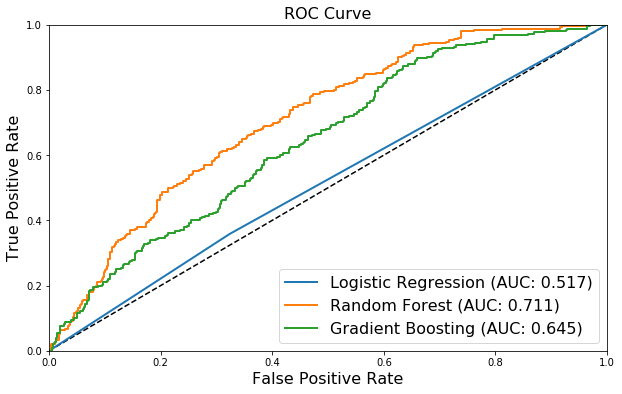

PR curves of MW and FCS with the cutoff that least 20% of hh are food insecure 
start printing PR curves


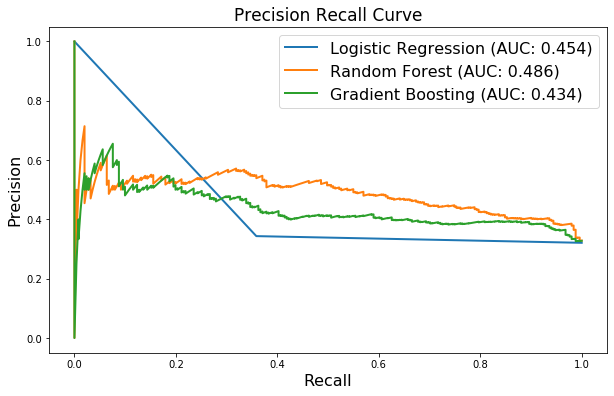

ROC curves of MW and rCSI with the cutoff that least 20% of hh are food insecure 
start printing ROC curves


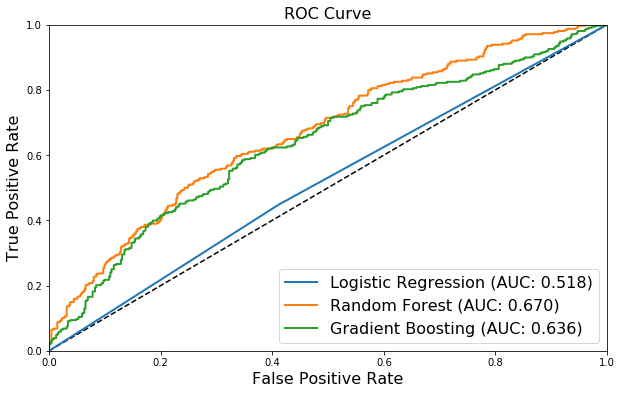

PR curves of MW and rCSI with the cutoff that least 20% of hh are food insecure 
start printing PR curves


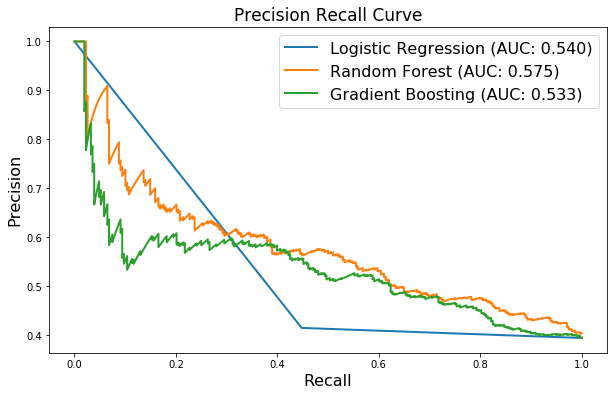

ROC curves of TZ and FCS with the cutoff that least 20% of hh are food insecure 
start printing ROC curves


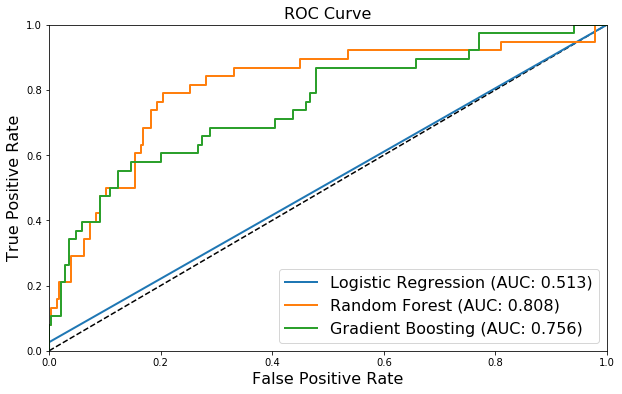

PR curves of TZ and FCS with the cutoff that least 20% of hh are food insecure 
start printing PR curves


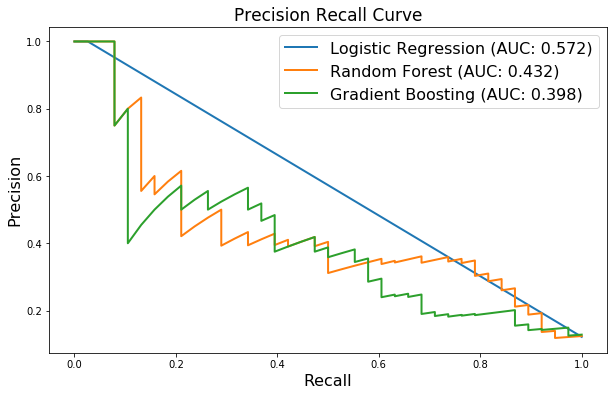

ROC curves of TZ and rCSI with the cutoff that least 20% of hh are food insecure 
start printing ROC curves


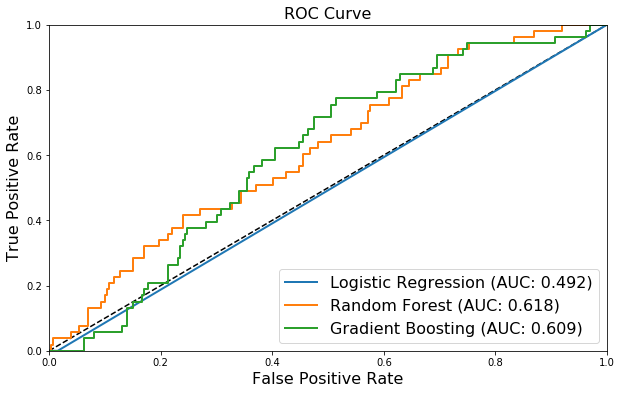

PR curves of TZ and rCSI with the cutoff that least 20% of hh are food insecure 
start printing PR curves


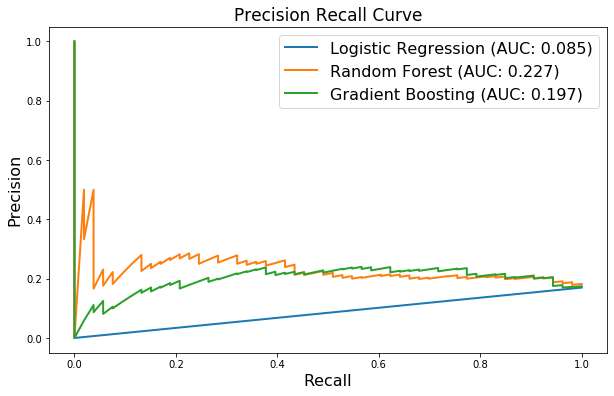

ROC curves of UG and FCS with the cutoff that least 20% of hh are food insecure 
start printing ROC curves


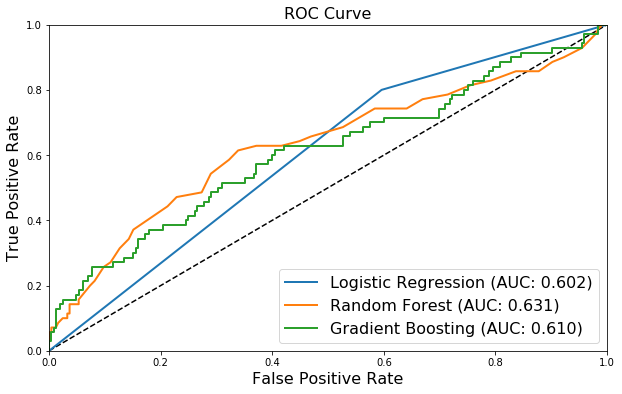

PR curves of UG and FCS with the cutoff that least 20% of hh are food insecure 
start printing PR curves


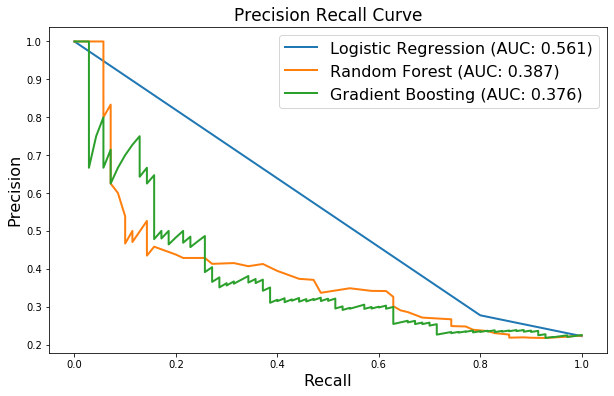

In [12]:
country_list = ["MW","TZ","UG"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="UG"):
            pass
        else:
            if country=="MW":
                df = mw_village
            elif country == "UG":
                df = ug_village
            elif country == "TZ":
                df = tz_village
                        
            
            roc_lr,roc_rf,roc_gb, pr_lr,pr_rf,pr_gb = roc_pr_values(country,df,measure,cut='20_bad')

            print ('ROC curves of ' + country + ' and ' + measure + ' with the cutoff that least 20% of hh are food insecure ')
            ROC_curve_plot(roc_lr,roc_rf,roc_gb )
            
            
            print ('PR curves of ' + country + ' and ' + measure + ' with the cutoff that least 20% of hh are food insecure ')
            pr_curve_plot(pr_lr,pr_rf,pr_gb)

### Upsample 

In [13]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

def upsample_minority(X_train,y_train):
        
    ros = RandomOverSampler(random_state=42,sampling_strategy='minority')
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
    
    return X_train_ros, y_train_ros
   

def smote_minority(X_train,y_train):
    
    smt = SMOTETomek(random_state=42,sampling_strategy='minority')

    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)
    
    return X_train_smote, y_train_smote 

def adasyn_minority(X_train,y_train):
    
    ada = ADASYN(random_state=42,n_jobs=5,sampling_strategy='minority')

    X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
    
    return X_train_ada, y_train_ada 

def upsample_training_set(country,df,measure,cut):
      
    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    category = measure + cut

    y_test = y_test_category[category]
    
    # Upsample 
    X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
    
    # error handling of cases where there's not enough minority cases 
    
    # SMOTE 
    try:
        X_train_smote,y_train_smote = smote_minority(X_train,y_train_category[category])
    except:
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
        X_train_smote,y_train_smote = smote_minority(X_train_upsampled,y_train_upsampled)
    
    # ADASYN
    try:
        X_train_adasyn,y_train_adasyn = adasyn_minority(X_train,y_train_category[category])
    except:
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
        X_train_adasyn,y_train_adasyn = adasyn_minority(X_train_upsampled,y_train_upsampled)

    return X_train,y_train_category[category],X_train_upsampled,y_train_upsampled,X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test

In [234]:

MW_FCS_rf_upsample = {'class_weight':[{0: 1, 1: 1000}],
'n_estimators':[160],'criterion':['gini'],'max_features':[15],
'max_depth':[15],'min_samples_split':[6],'min_samples_leaf':[9]}

MW_FCS_rf_smote = {'class_weight':['balanced_subsample'],
'n_estimators':[160],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[9]}

MW_FCS_rf_adasyn = {'class_weight':['balanced_subsample'],
'n_estimators':[170],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[5],'min_samples_leaf':[9]}


MW_rCSI_rf_upsample={'class_weight':['balanced_subsample'],
'n_estimators':[120],'criterion':['gini'],'max_features':[12],
'max_depth':[10],'min_samples_split':[6],'min_samples_leaf':[6]}

MW_rCSI_rf_smote={'class_weight':[{0: 1, 1: 10}],
'n_estimators':[160],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[4],'min_samples_leaf':[9]}

MW_rCSI_rf_adasyn={'class_weight':['balanced_subsample'],
'n_estimators':[120],'criterion':['entropy'],'max_features':[12],
'max_depth':[5],'min_samples_split':[8],'min_samples_leaf':[9]}


TZ_FCS_rf_upsample = {'class_weight':['balanced_subsample'],
'n_estimators':[160],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[4],'min_samples_leaf':[9]}

TZ_FCS_rf_smote = {'class_weight':['balanced_subsample'],
'n_estimators':[160],'criterion':['gini'],'max_features':[15],
'max_depth':[5],'min_samples_split':[4],'min_samples_leaf':[10]}


TZ_FCS_rf_adasyn = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[130],'criterion':['gini'],'max_features':[10],
'max_depth':[10],'min_samples_split':[4],'min_samples_leaf':[8]}



TZ_rCSI_rf_upsample = {'class_weight':[{0: 2, 1: 8}],
'n_estimators':[150],'criterion':['gini'],'max_features':[15],
'max_depth':[10],'min_samples_split':[5],'min_samples_leaf':[3]}

TZ_rCSI_rf_smote = {'class_weight':[{0: 1, 1: 10}],
'n_estimators':[160],'criterion':['gini'],'max_features':[20],
'max_depth':[10],'min_samples_split':[4],'min_samples_leaf':[4]}

TZ_rCSI_rf_adasyn = {'class_weight':[{0: 1, 1: 100}],
'n_estimators':[160],'criterion':['entropy'],'max_features':[20],
'max_depth':[5],'min_samples_split':[6],'min_samples_leaf':[4]}


UG_FCS_rf_upsample= {'class_weight':['balanced_subsample'],
'n_estimators':[140],'criterion':['gini'],'max_features':[15],
'max_depth':[15],'min_samples_split':[6],'min_samples_leaf':[9]}

UG_FCS_rf_smote= {'class_weight':['balanced_subsample'],
'n_estimators':[140],'criterion':['gini'],'max_features':[15],
'max_depth':[15],'min_samples_split':[4],'min_samples_leaf':[8]}

UG_FCS_rf_adasyn= {'class_weight':['balanced_subsample'],
'n_estimators':[150],'criterion':['gini'],'max_features':[15],
'max_depth':[15],'min_samples_split':[4],'min_samples_leaf':[8]}



   

In [235]:
def roc_pr_values_upsample_rf(X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test):
       
    param_grid_rf_upsample =  eval(country+'_'+measure+'_'+'rf'+'_upsample') 
    param_grid_rf_smote =  eval(country+'_'+measure+'_'+'rf'+'_smote') 
    param_grid_rf_adasyn =  eval(country+'_'+measure+'_'+'rf'+'_adasyn') 

    # rfc_upsample
    y_prob,y_test  = rfCLF(X_train_upsampled,y_train_upsampled,X_test,y_test,param_grid=param_grid_rf_upsample,prob=True)

    # ROC curve values
    fpr_rf_upsample, tpr_rf_upsample, thresholds = roc_curve(y_test, y_prob)
    auc_roc_rf_upsample = auc(fpr_rf_upsample, tpr_rf_upsample)

    # PR curve values  
    precision_rf_upsample, recall_rf_upsample, thresholds = precision_recall_curve(y_test, y_prob)
    auc_pr_rf_upsample =  auc(recall_rf_upsample,precision_rf_upsample)

    # rfc smote
    y_prob,y_test  = rfCLF(X_train_smote,y_train_smote,X_test,y_test,param_grid=param_grid_rf_smote,prob=True)

    # ROC curve values
    fpr_rf_smote, tpr_rf_smote, thresholds = roc_curve(y_test, y_prob)
    auc_roc_rf_smote = auc(fpr_rf_smote, tpr_rf_smote)

    # PR curve values  
    precision_rf_smote, recall_rf_smote, thresholds = precision_recall_curve(y_test, y_prob)
    auc_pr_rf_smote =  auc(recall_rf_smote,precision_rf_smote)

    # rfc adasyn
    y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,param_grid=param_grid_rf_adasyn,prob=True)

    # ROC curve values
    fpr_rf_adasyn, tpr_rf_adasyn, thresholds = roc_curve(y_test, y_prob)
    auc_roc_rf_adasyn = auc(fpr_rf_adasyn, tpr_rf_adasyn)

    # PR curve values  
    precision_rf_adasyn, recall_rf_adasyn, thresholds = precision_recall_curve(y_test, y_prob)
    auc_pr_rf_adasyn =  auc(recall_rf_adasyn,precision_rf_adasyn)

    roc_rf_upsample = [tpr_rf_upsample,fpr_rf_upsample,auc_roc_rf_upsample]
    pr_rf_upsample = [precision_rf_upsample,recall_rf_upsample,auc_pr_rf_upsample]

    roc_rf_smote = [tpr_rf_smote,fpr_rf_smote,auc_roc_rf_smote]
    pr_rf_smote = [precision_rf_smote,recall_rf_smote,auc_pr_rf_smote]

    roc_rf_adasyn = [tpr_rf_adasyn,fpr_rf_adasyn,auc_roc_rf_adasyn]
    pr_rf_adasyn = [precision_rf_adasyn,recall_rf_adasyn,auc_pr_rf_adasyn]

    return roc_rf_upsample,pr_rf_upsample,roc_rf_smote,pr_rf_smote,roc_rf_adasyn,pr_rf_adasyn

  
 
     

In [236]:
 
def ROC_curve_up_plot(roc_lr,roc_rf, roc_gb,roc_rf_upsample,roc_rf_smote,roc_rf_adasyn):
    '''
    roc curve plotting
    '''
    
    print("start printing ROC curve")
    
    
    tpr_lr,fpr_lr,auc_lr = roc_lr
    tpr_rf,fpr_rf,auc_rf = roc_rf
    tpr_gb,fpr_gb,auc_gb = roc_gb
    tpr_rf_upsample,fpr_rf_upsample,auc_rf_upsample = roc_rf_upsample
    tpr_rf_smote,fpr_rf_smote,auc_rf_smote = roc_rf_smote
    tpr_rf_adasyn,fpr_rf_adasyn,auc_rf_adasyn = roc_rf_adasyn
    
    # ROC curve 
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])


    plt.plot(fpr_lr,tpr_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
    plt.plot(fpr_rf,tpr_rf,label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
    plt.plot(fpr_gb,tpr_gb,label="Gradient Boosting (AUC: {:.3f})".format(auc_gb),linewidth=2)
    plt.plot(fpr_rf_upsample,tpr_rf_upsample,label="UPSAMPLE Random Forest (AUC: {:.3f})".format(auc_rf_upsample),linewidth=2)
    plt.plot(fpr_rf_smote,tpr_rf_smote,label="SMOTE Random Forest (AUC: {:.3f})".format(auc_rf_smote),linewidth=2)
    plt.plot(fpr_rf_adasyn,tpr_rf_adasyn,label="ADASYN Random Forest (AUC: {:.3f})".format(auc_rf_adasyn),linewidth=2)
    
    plt.xlabel("False Positive Rate",fontsize=16)
    plt.ylabel("True Positive Rate",fontsize=16)
    plt.title("ROC Curve",fontsize=16)
    plt.legend(loc="lower right",fontsize=16) 
    
     
    return plt.show()

                     

In [237]:
def pr_curve_up_plot(pr_lr,pr_rf,pr_gb, pr_rf_upsample,pr_rf_smote,pr_rf_adasyn):
    '''
    pr curve plotting
    '''
    
    print("start printing PR curve")
    
    precision_lr,recall_lr,auc_lr = pr_lr
    precision_rf,recall_rf,auc_rf = pr_rf
    precision_gb,recall_gb,auc_gb = pr_gb

    precision_rf_upsample,recall_rf_upsample,auc_rf_upsample = pr_rf_upsample
    precision_rf_smote,recall_rf_smote,auc_rf_smote = pr_rf_smote
    precision_rf_adasyn,recall_rf_adasyn,auc_rf_adasyn = pr_rf_adasyn
    
    # PR CURVE 
    plt.figure(figsize=(10,6))
    plt.plot(recall_lr,precision_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
    plt.plot(recall_rf,precision_rf,label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
    plt.plot(recall_gb,precision_gb,label="Gradient Boosting (AUC: {:.3f})".format(auc_rf),linewidth=2)
    plt.plot(recall_rf_upsample,precision_rf_upsample,label="UPSAMPLE Random Forest (AUC: {:.3f})".format(auc_rf_upsample),linewidth=2)
    plt.plot(recall_rf_smote,precision_rf_smote,label="SMOTE Random Forest (AUC: {:.3f})".format(auc_rf_smote),linewidth=2)
    plt.plot(recall_rf_adasyn,precision_rf_adasyn,label="ADASYN Random Forest (AUC: {:.3f})".format(auc_rf_adasyn),linewidth=2)

    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.title("Precision Recall Curve",fontsize=17)
    plt.legend(fontsize=16)
    
    return plt.show()


#### Figure 2 

start printing ROC curve


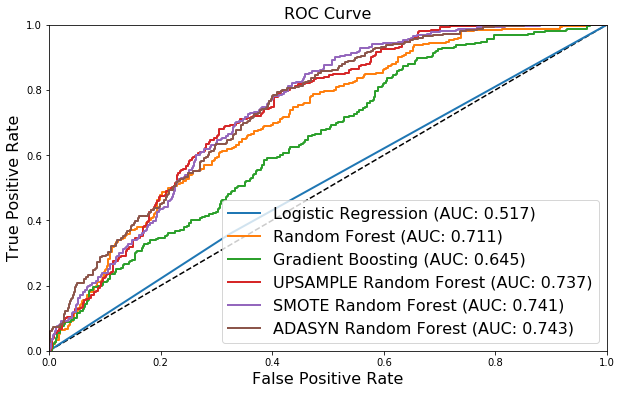

start printing PR curve


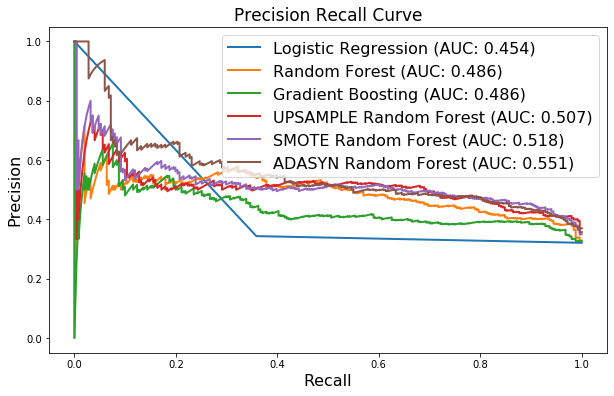

start printing ROC curve


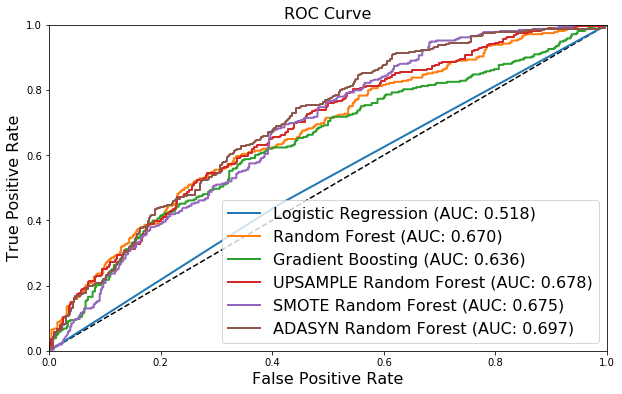

start printing PR curve


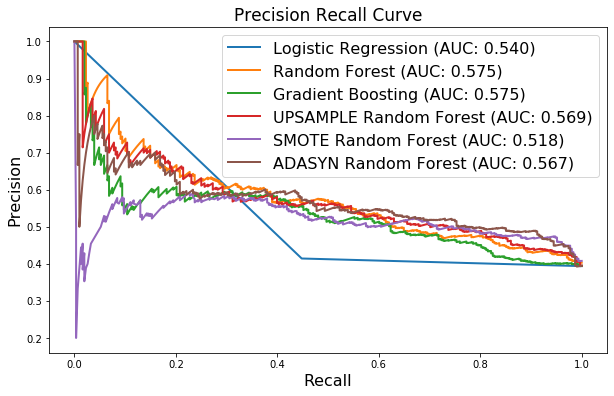

start printing ROC curve


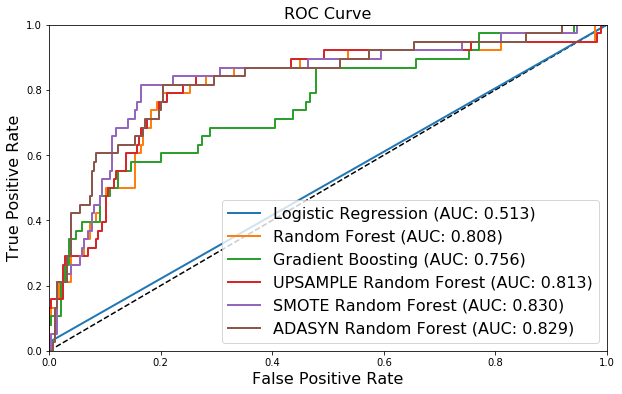

start printing PR curve


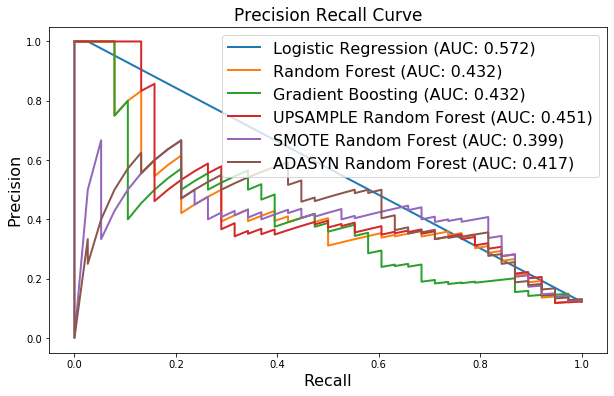

start printing ROC curve


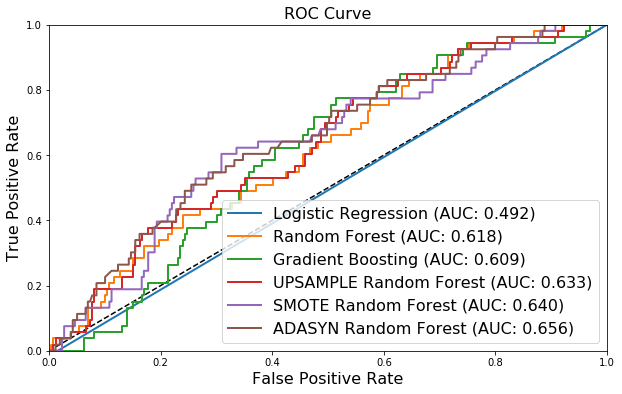

start printing PR curve


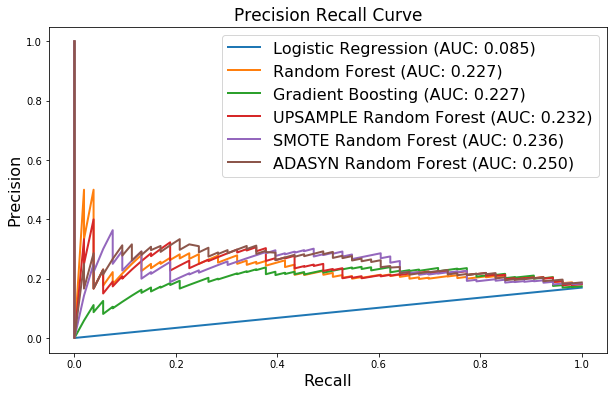

start printing ROC curve


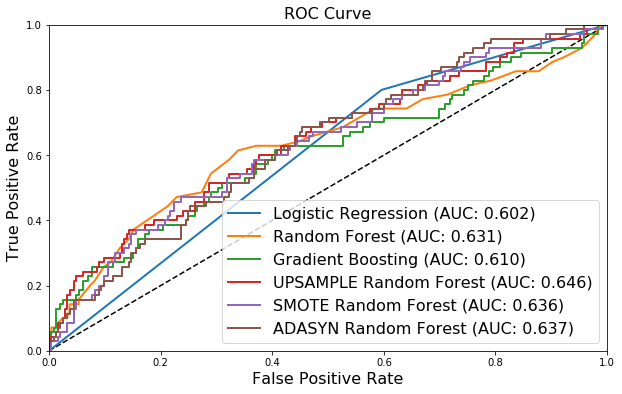

start printing PR curve


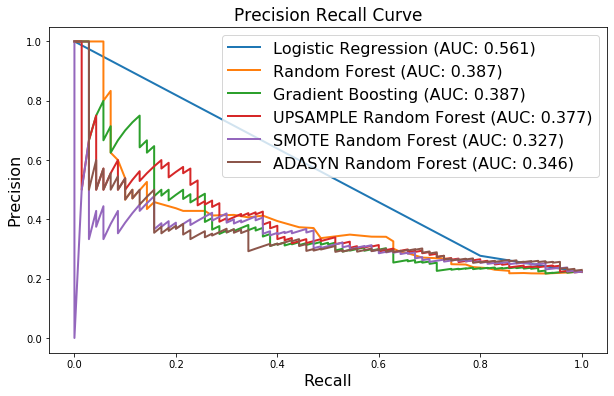

In [238]:
country_list = ["MW","TZ","UG"]
measure_list = ["FCS","rCSI"]

cut='_20_bad'

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="UG"):
            pass
        else:
            if country=="MW":
                df = mw_village
            elif country == "UG":
                df = ug_village
            elif country == "TZ":
                df = tz_village
            
            


            X_train,y_train,X_train_upsampled,y_train_upsampled,X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn, X_test,y_test =upsample_training_set(country,df,measure,cut)
                       
            roc_lr,roc_rf,roc_gb, pr_lr,pr_rf,pr_gb = roc_pr_values(country,df,measure,cut='20_bad')

            roc_rf_upsample,pr_rf_upsample,roc_rf_smote,pr_rf_smote,roc_rf_adasyn,pr_rf_adasyn = roc_pr_values_upsample_rf(X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test)
  
            ROC_curve_up_plot(roc_lr,roc_rf,roc_gb, roc_rf_upsample,roc_rf_smote,roc_rf_adasyn)
            pr_curve_up_plot(pr_lr,pr_rf, pr_gb,pr_rf_upsample,pr_rf_smote,pr_rf_adasyn)



### Choice of threshold and classification reports

#### Plot threshold spikes on recall for each case 

go one by one to find the optimal threshold that maximizes precision
and recall


In [239]:
def threshold_plot(country,df,measure,cut):
    
    '''
    Define a function that calcualtes the values for roc and pr curves 
    '''
    
    from sklearn.calibration import calibration_curve
    from sklearn.metrics import average_precision_score

    
    category = measure + '_' + cut
    
    # category = measure + '_' + 'binary_safe'
    # category = measure + '_' + 'binary_bad'
    # category = measure + '_' + '20_bad'


    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    param_grid_lr = eval(country+'_'+measure+'_'+cut + '_lr') 
    param_grid_rf = eval(country+'_'+measure+'_'+cut + '_rf') 
    param_grid_gb = eval(country+'_'+measure+'_'+cut + '_gb') 
       
    #########################################
    # baseline model using logistic regression 
    #########################################
    plt.figure(figsize = (10,20))
    ax0 = plt.subplot2grid((9,1),(0,0),rowspan=2)
    ax1 = plt.subplot2grid((9,1),(2,0),rowspan=2)
    ax2 = plt.subplot2grid((9,1),(4,0),rowspan=2)
    ax3 = plt.subplot2grid((9,1),(4,0),rowspan=2)
    ax4 = plt.subplot2grid((9,1),(6,0))
        
    y_prob_lr,y_test = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                               param_grid=param_grid_lr,prob=False)
    
    y_prob_rf,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_rf,prob=True)
    
    y_prob_gb,y_test  = gbCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_gb,prob=True)
    
    for index in range(3):
        
        y_prob_list = [y_prob_lr,y_prob_rf,y_prob_gb]
        model_list = ["Logistic Regression","Random Forest", "Gradient Boost"]
        
        y_prob = y_prob_list[index]
        model_name = country + " " + measure + " " + model_list[index]
        
        # ROC curve values
        fpr,tpr,threshold = roc_curve(y_test, y_prob)
        auc_roc = auc(fpr,tpr)

        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins = 10)
        precisions,recalls, thresholds = precision_recall_curve(y_test,y_prob)
        avg_precision = average_precision_score(y_test,y_prob)


        ax0.plot(fpr,tpr,
                label = '%s ROC CURVE (AUC= %0.2f)' % (model_name,auc_roc))

        ax1.step(recalls,precisions,
                label = '%s PR CURVE (avg precision= %0.2f)' % (model_name,avg_precision))

        ax2.plot(mean_predicted_value,fraction_of_positives, "s-",
                label = '%s' % (model_name))

        ax3.plot(thresholds,precisions[:-1],'--',label = 'precision %s' % (model_name ) )
        ax3.plot(thresholds,recalls[:-1],'--',label = 'recall %s' % (model_name ) )

        ax4.hist(y_prob,range = (0,1), bins=10,label = model_name,histtype="step",lw=2 )
    
    ax0.plot([0,1],[0,1],color='navy',linestyle = '--', label='chance')
    ax0.set_xlabel('False positive rates')
    ax0.set_ylabel('True positive rates')
    ax0.set_title('Receiver operating characteritics')
    ax0.legend(loc="upper left",ncol=2)    
     
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('2-class Precision-recall curve')
    ax1.legend(loc="upper left",ncol=2)
    
    ax2.plot([0,1],[0,1],"k:", label='Perfectly calibrated')
    ax2.set_ylim([-0.05,1.05])
    ax2.legend(loc="upper left",ncol=2)
    ax2.set_title('Calibration plot (reliability )')
    
    ax3.set_xlabel('Threshold')
    ax3.legend(loc="upper left",ncol=2)
        
    ax4.set_xlabel('Mean predicted value')
    ax4.set_ylabel("Count")
    ax4.legend(loc="upper left",ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    


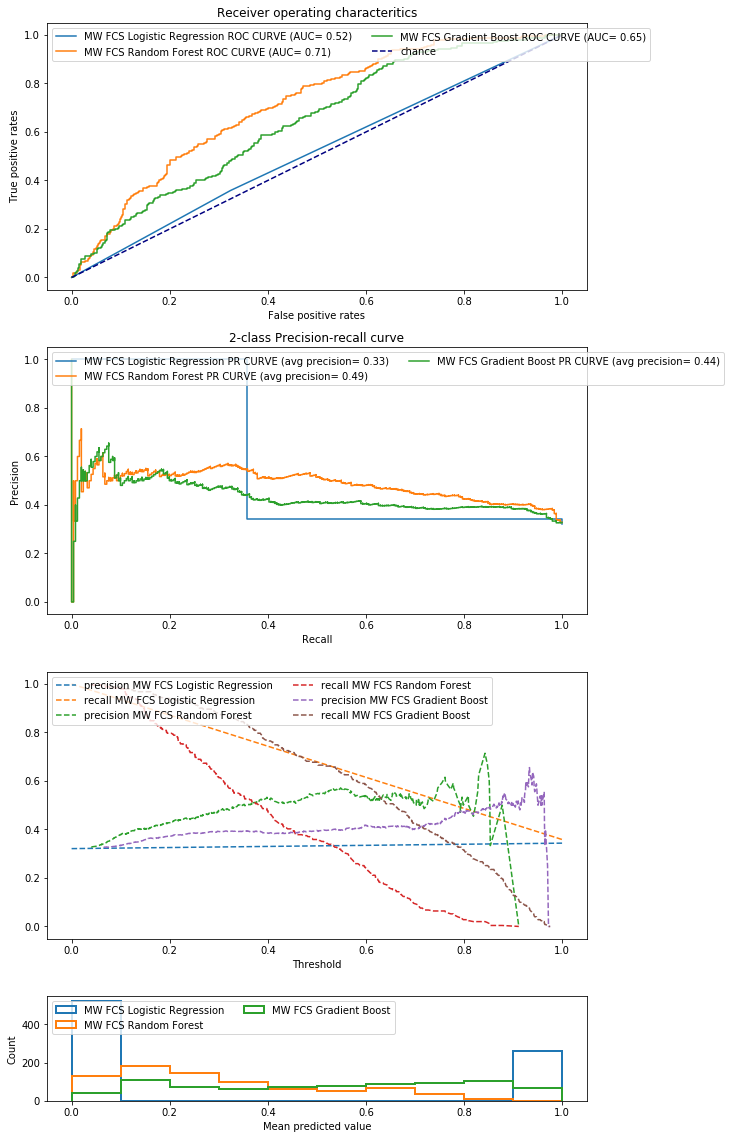

In [240]:
country="MW"
df = mw_village
measure = 'FCS'
category = '20_'+'bad'
    
threshold_plot("MW",df,'FCS',category)
    

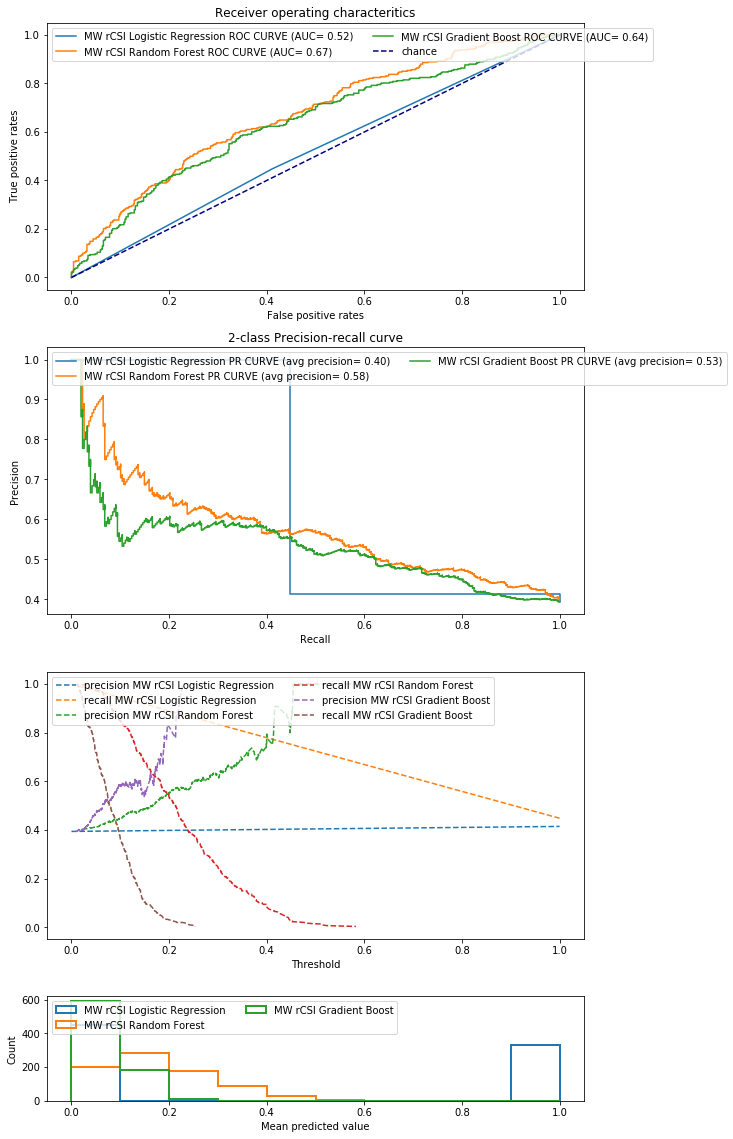

In [241]:
country="MW"
df = mw_village
measure = 'rCSI'
category = '20_'+'bad'
    
threshold_plot("MW",df,'rCSI',category)

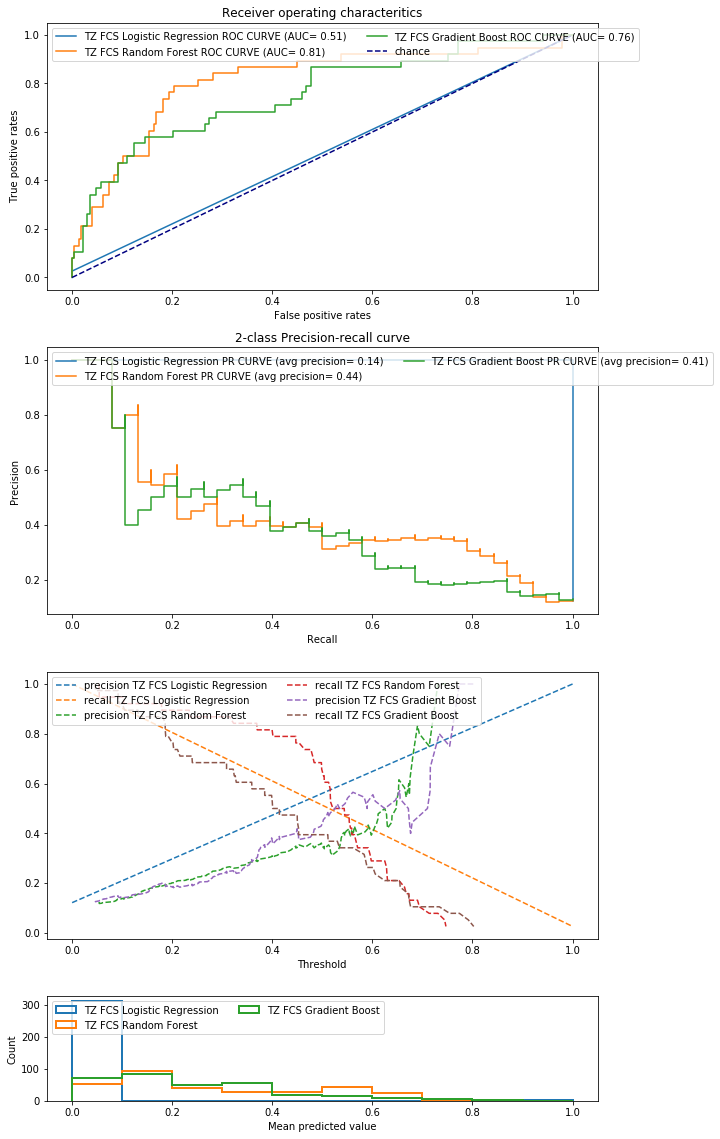

In [242]:
country="TZ"
df = tz_village
measure = 'FCS'
category = '20_'+'bad'

threshold_plot("TZ",df,'FCS',category)

     

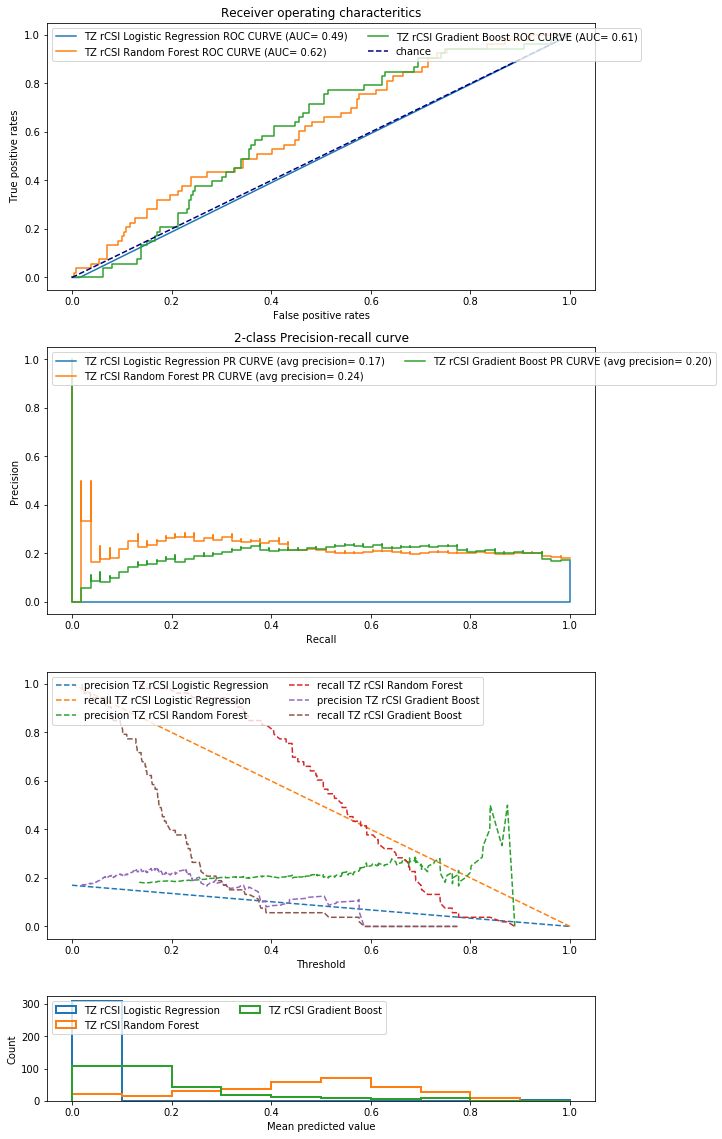

In [243]:
country="TZ"
df = tz_village
measure = 'rCSI'
category = '20_'+'bad'

threshold_plot("TZ",df,'rCSI',category)

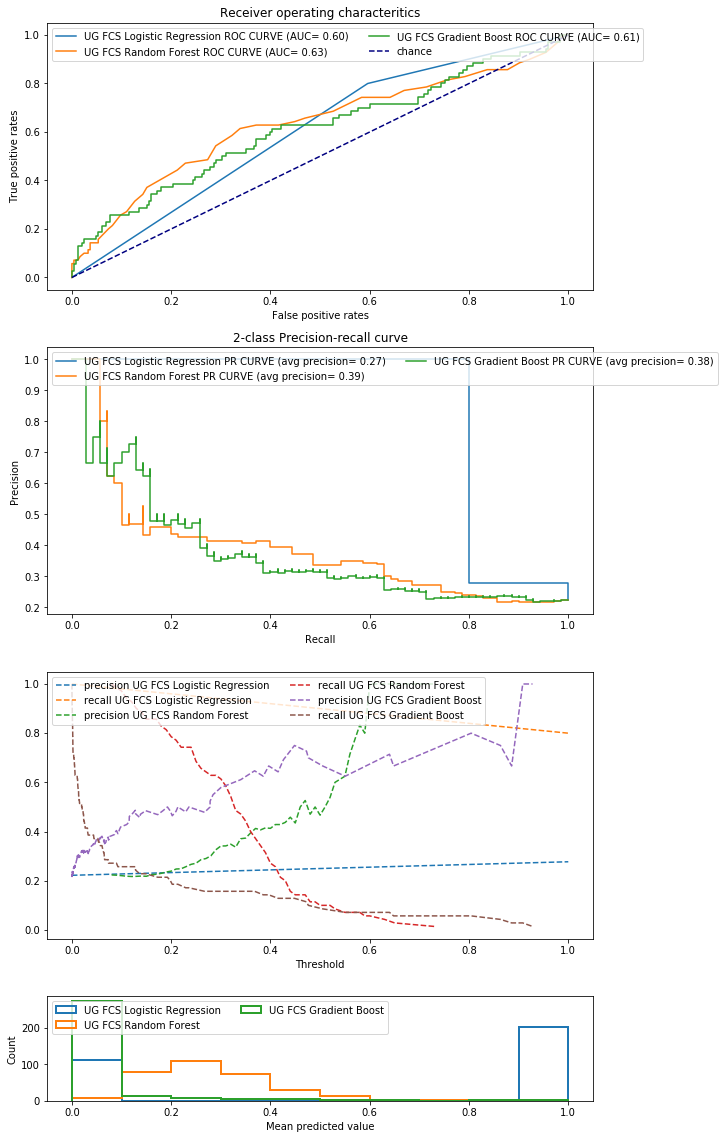

In [244]:
country="UG"
df = ug_village
measure='FCS'
category = '20_'+'bad'

threshold_plot("UG",df,'FCS',category) 

### Table 2 Precision@Recall70 & Precision@Recall90

In [245]:
def pr_re_threshold(country,df,measure,cut,lr_threshold,rf_threshold,gb_threshold):
        
    category = measure + '_' + cut
    
    # category = measure + '_' + 'binary_safe'
    # category = measure + '_' + 'binary_bad'
    # category = measure + '_' + '20_bad'
    
    class_names = ['majority_class','minority_class']
    
    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    param_grid_lr = eval(country+'_'+measure+'_'+cut + '_lr') 
    param_grid_rf = eval(country+'_'+measure+'_'+cut + '_rf') 
    param_grid_gb = eval(country+'_'+measure+'_'+cut + '_gb') 

    y_prob_lr,y_test = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                               param_grid=param_grid_lr,prob=False)
    
    y_prob_rf,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_rf,prob=True)
    
    y_prob_gb,y_test  = gbCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_gb,prob=True)
    
    lr_y_pred = np.where(y_prob_lr>= lr_threshold ,1,0)
    
    rf_y_pred = np.where(y_prob_rf>= rf_threshold ,1,0)
    
    gb_y_pred = np.where(y_prob_gb>= gb_threshold ,1,0)
    
    print ("----------------lr model---------------- \n",
           classification_report(y_test, lr_y_pred, target_names = class_names),'\n'  )
   
    print ("----------------rfc model---------------- \n",
           classification_report(y_test, rf_y_pred, target_names = class_names),'\n'  )
   
    print ("----------------gbc model---------------- \n",
           classification_report(y_test, gb_y_pred, target_names = class_names),'\n'  )
   

In [253]:
country="MW"
df = mw_village
measure = 'FCS'
category = '20_'+'bad'
    
# precision @ recall 70 thresholds 

pr_re_threshold("MW",df,'FCS',category,0 ,0.255,0.47)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       531
minority_class       0.32      1.00      0.49       251

      accuracy                           0.32       782
     macro avg       0.16      0.50      0.24       782
  weighted avg       0.10      0.32      0.16       782
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.81      0.60      0.69       531
minority_class       0.45      0.70      0.55       251

      accuracy                           0.63       782
     macro avg       0.63      0.65      0.62       782
  weighted avg       0.69      0.63      0.64       782
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.77      0.48      0.59       531
minority_class       0.39      0.70      0.50       251

      accuracy   

In [252]:
country="MW"
df = mw_village
measure = 'FCS'
category = '20_'+'bad'

# precision @ recall 90 thresholds 
pr_re_threshold("MW",df,'FCS',category,0.00,0.145,0.285)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       531
minority_class       0.32      1.00      0.49       251

      accuracy                           0.32       782
     macro avg       0.16      0.50      0.24       782
  weighted avg       0.10      0.32      0.16       782
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.36      0.52       531
minority_class       0.40      0.90      0.56       251

      accuracy                           0.54       782
     macro avg       0.65      0.63      0.54       782
  weighted avg       0.73      0.54      0.53       782
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.87      0.34      0.49       531
minority_class       0.39      0.90      0.54       251

      accuracy   

In [260]:
country="MW"
df = mw_village
measure = 'rCSI'
category = '20_'+'bad'

# precision @ recall 70 thresholds 

pr_re_threshold("MW",df,'rCSI',category,0.0
            ,0.145,0.052)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       474
minority_class       0.39      1.00      0.57       308

      accuracy                           0.39       782
     macro avg       0.20      0.50      0.28       782
  weighted avg       0.16      0.39      0.22       782
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.72      0.51      0.60       474
minority_class       0.48      0.70      0.57       308

      accuracy                           0.58       782
     macro avg       0.60      0.60      0.58       782
  weighted avg       0.63      0.58      0.59       782
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.72      0.50      0.59       474
minority_class       0.48      0.70      0.57       308

      accuracy   

In [264]:
country="MW"
df = mw_village
measure = 'rCSI'
category = '20_'+'bad'

# precision @ recall 90 thresholds 

pr_re_threshold("MW",df,'rCSI',category,0,0.082,0.026)

 

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       474
minority_class       0.39      1.00      0.57       308

      accuracy                           0.39       782
     macro avg       0.20      0.50      0.28       782
  weighted avg       0.16      0.39      0.22       782
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.78      0.23      0.36       474
minority_class       0.43      0.90      0.58       308

      accuracy                           0.50       782
     macro avg       0.61      0.57      0.47       782
  weighted avg       0.64      0.50      0.45       782
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.68      0.14      0.23       474
minority_class       0.40      0.90      0.56       308

      accuracy   

In [282]:
country="TZ"
df = tz_village
measure = 'FCS'
category = '20_'+'bad'

# precision @ recall 70 thresholds 

pr_re_threshold("TZ",df,'FCS',category,0.00
            ,0.478,0.230)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       274
minority_class       0.12      1.00      0.22        38

      accuracy                           0.12       312
     macro avg       0.06      0.50      0.11       312
  weighted avg       0.01      0.12      0.03       312
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.82      0.88       274
minority_class       0.35      0.71      0.47        38

      accuracy                           0.80       312
     macro avg       0.65      0.76      0.67       312
  weighted avg       0.88      0.80      0.83       312
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.58      0.72       274
minority_class       0.19      0.71      0.30        38

      accuracy   

In [278]:
country="TZ"
df = tz_village
measure = 'FCS'
category = '20_'+'bad'

# precision @ recall 90 thresholds 

pr_re_threshold("TZ",df,'FCS',category,0.00
            ,0.177,0.100)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       274
minority_class       0.12      1.00      0.22        38

      accuracy                           0.12       312
     macro avg       0.06      0.50      0.11       312
  weighted avg       0.01      0.12      0.03       312
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.46      0.63       274
minority_class       0.19      0.92      0.32        38

      accuracy                           0.52       312
     macro avg       0.58      0.69      0.47       312
  weighted avg       0.88      0.52      0.59       312
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.96      0.25      0.39       274
minority_class       0.15      0.92      0.25        38

      accuracy   

In [305]:
country="TZ"
df = tz_village
measure = 'rCSI'
category = '20_'+'bad'

# precision @ recall 70 thresholds 

pr_re_threshold("TZ",df,'rCSI',category,0.00
            ,0.45,0.138)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       259
minority_class       0.17      1.00      0.29        53

      accuracy                           0.17       312
     macro avg       0.08      0.50      0.15       312
  weighted avg       0.03      0.17      0.05       312
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.88      0.44      0.59       259
minority_class       0.20      0.70      0.31        53

      accuracy                           0.48       312
     macro avg       0.54      0.57      0.45       312
  weighted avg       0.76      0.48      0.54       312
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.90      0.53      0.66       259
minority_class       0.24      0.72      0.36        53

      accuracy   

In [304]:
country="TZ"
df = tz_village
measure = 'rCSI'
category = '20_'+'bad'

# precision @ recall 90 thresholds 

pr_re_threshold("TZ",df,'rCSI',category,0.00
            ,0.343,0.075)
    

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       259
minority_class       0.17      1.00      0.29        53

      accuracy                           0.17       312
     macro avg       0.08      0.50      0.15       312
  weighted avg       0.03      0.17      0.05       312
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.28      0.43       259
minority_class       0.21      0.91      0.33        53

      accuracy                           0.39       312
     macro avg       0.57      0.59      0.38       312
  weighted avg       0.81      0.39      0.42       312
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.29      0.45       259
minority_class       0.21      0.91      0.34        53

      accuracy   

In [318]:
country="UG"
df = ug_village
measure='FCS'
category = '20_'+'bad'

# precision @ recall 70 thresholds 


pr_re_threshold("UG",df,'FCS',category,0.7,0.240,0.0040) 

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.88      0.40      0.55       245
minority_class       0.28      0.80      0.41        70

      accuracy                           0.49       315
     macro avg       0.58      0.60      0.48       315
  weighted avg       0.74      0.49      0.52       315
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.85      0.42      0.56       245
minority_class       0.27      0.74      0.39        70

      accuracy                           0.49       315
     macro avg       0.56      0.58      0.48       315
  weighted avg       0.72      0.49      0.52       315
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.83      0.42      0.56       245
minority_class       0.26      0.70      0.38        70

      accuracy   

In [310]:
country="UG"
df = ug_village
measure='FCS'
category = '20_'+'bad'

# precision @ recall 90 thresholds 


pr_re_threshold("UG",df,'FCS',category,0.00,0.13,0.0007) 

----------------lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.00      0.00      0.00       245
minority_class       0.22      1.00      0.36        70

      accuracy                           0.22       315
     macro avg       0.11      0.50      0.18       315
  weighted avg       0.05      0.22      0.08       315
 

----------------rfc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.73      0.08      0.14       245
minority_class       0.22      0.90      0.35        70

      accuracy                           0.26       315
     macro avg       0.47      0.49      0.25       315
  weighted avg       0.62      0.26      0.19       315
 

----------------gbc model---------------- 
                 precision    recall  f1-score   support

majority_class       0.86      0.17      0.29       245
minority_class       0.24      0.90      0.38        70

      accuracy   

### Table 3 with upsamplePrecision@Recall70 & Precision@Recall90 

In [319]:

def pr_re_upsample_threshold(country,df,measure,cut,upsample_threshold,smote_threshold,adasyn_threshold):
    
    class_names = ['majority_class','minority_class']
    
    category = measure + '_' + cut
    
    param_grid_rf_upsample =  eval(country+'_'+measure+'_'+'rf'+'_upsample') 
    param_grid_rf_smote =  eval(country+'_'+measure+'_'+'rf'+'_smote') 
    param_grid_rf_adasyn =  eval(country+'_'+measure+'_'+'rf'+'_adasyn') 

    X_train,y_train,X_train_upsampled,y_train_upsampled,X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn, X_test,y_test =upsample_training_set(country,df,measure,cut)
    
    # rfc_upsample
    y_prob_upsample,y_test  = rfCLF(X_train_upsampled,y_train_upsampled,X_test,y_test,param_grid=param_grid_rf_upsample,prob=True)

    # rfc smote
    y_prob_smote,y_test  = rfCLF(X_train_smote,y_train_smote,X_test,y_test,param_grid=param_grid_rf_smote,prob=True)
    
    # rfc adasyn
    y_prob_adasyn,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,param_grid=param_grid_rf_adasyn,prob=True)

    
    upsample_y_pred = np.where(y_prob_upsample>= upsample_threshold ,1,0)
    
    smote_y_pred = np.where(y_prob_smote>= smote_threshold,1,0)
    
    adasyn_y_pred = np.where(y_prob_adasyn>= adasyn_threshold,1,0)
    
    print ("----------------upsample model---------------- \n",
           classification_report(y_test, upsample_y_pred, target_names = class_names),'\n'  )
   
    print ("----------------smote model---------------- \n",
           classification_report(y_test, smote_y_pred, target_names = class_names),'\n'  )
   
    print ("----------------adasyn model---------------- \n",
           classification_report(y_test, adasyn_y_pred, target_names = class_names),'\n'  )
   

In [348]:
country="MW"
df = mw_village
measure='FCS'
cut = '_20_'+'bad'

# precision @ recall 70 thresholds 


pr_re_upsample_threshold("MW",df,'FCS',cut,0.235,0.40,0.394) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.82      0.66      0.73       531
minority_class       0.49      0.70      0.58       251

      accuracy                           0.67       782
     macro avg       0.66      0.68      0.65       782
  weighted avg       0.72      0.67      0.68       782
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.82      0.66      0.74       531
minority_class       0.50      0.70      0.58       251

      accuracy                           0.68       782
     macro avg       0.66      0.68      0.66       782
  weighted avg       0.72      0.68      0.69       782
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.82      0.65      0.72       531
minority_class       0.48      0.70      0.57       251

      

In [349]:
country="MW"
df = mw_village
measure='FCS'
cut = '_20_'+'bad'

# precision @ recall 90 thresholds 

pr_re_upsample_threshold("MW",df,'FCS',cut,0.1365,0.2848,0.262) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.90      0.42      0.57       531
minority_class       0.42      0.90      0.58       251

      accuracy                           0.57       782
     macro avg       0.66      0.66      0.57       782
  weighted avg       0.75      0.57      0.57       782
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      0.45      0.61       531
minority_class       0.44      0.91      0.59       251

      accuracy                           0.60       782
     macro avg       0.68      0.68      0.60       782
  weighted avg       0.76      0.60      0.60       782
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.91      0.43      0.59       531
minority_class       0.43      0.90      0.58       251

      

In [367]:
country="MW"
df = mw_village
measure='rCSI'
cut = '_20_'+'bad'

# precision @ recall 70 thresholds 


pr_re_upsample_threshold("MW",df,'rCSI',cut,0.155,0.255,0.296) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.74      0.55      0.63       474
minority_class       0.50      0.70      0.59       308

      accuracy                           0.61       782
     macro avg       0.62      0.63      0.61       782
  weighted avg       0.65      0.61      0.61       782
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.74      0.57      0.65       474
minority_class       0.51      0.70      0.59       308

      accuracy                           0.62       782
     macro avg       0.63      0.63      0.62       782
  weighted avg       0.65      0.62      0.62       782
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.75      0.57      0.65       474
minority_class       0.52      0.71      0.60       308

      

In [368]:
country="MW"
df = mw_village
measure='rCSI'
cut = '_20_'+'bad'

# precision @ recall 90 thresholds 


pr_re_upsample_threshold("MW",df,'rCSI',cut,0.108,0.099,0.180) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.80      0.26      0.39       474
minority_class       0.44      0.90      0.59       308

      accuracy                           0.51       782
     macro avg       0.62      0.58      0.49       782
  weighted avg       0.66      0.51      0.47       782
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.83      0.34      0.48       474
minority_class       0.47      0.90      0.61       308

      accuracy                           0.56       782
     macro avg       0.65      0.62      0.55       782
  weighted avg       0.69      0.56      0.53       782
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.85      0.39      0.53       474
minority_class       0.49      0.90      0.63       308

      

In [387]:
country="TZ"
df = tz_village
measure='FCS'
cut = '_20_'+'bad'

# precision @ recall 70 thresholds 


pr_re_upsample_threshold("TZ",df,'FCS',cut,0.572,0.615,0.704) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.82      0.88       274
minority_class       0.36      0.71      0.47        38

      accuracy                           0.81       312
     macro avg       0.65      0.77      0.68       312
  weighted avg       0.88      0.81      0.83       312
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.96      0.85      0.90       274
minority_class       0.40      0.71      0.51        38

      accuracy                           0.84       312
     macro avg       0.68      0.78      0.71       312
  weighted avg       0.89      0.84      0.85       312
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.83      0.89       274
minority_class       0.36      0.71      0.48        38

      

In [422]:
country="TZ"
df = tz_village
measure='FCS'
cut = '_20_'+'bad'

# precision @ recall 90 thresholds 


pr_re_upsample_threshold("TZ",df,'FCS',cut,0.244,0.128,0.283) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.51      0.67       274
minority_class       0.21      0.92      0.34        38

      accuracy                           0.56       312
     macro avg       0.59      0.71      0.50       312
  weighted avg       0.88      0.56      0.63       312
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.97      0.40      0.57       274
minority_class       0.18      0.92      0.30        38

      accuracy                           0.46       312
     macro avg       0.57      0.66      0.43       312
  weighted avg       0.88      0.46      0.54       312
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.97      0.43      0.59       274
minority_class       0.18      0.92      0.30        38

      

In [435]:
country="TZ"
df = tz_village
measure='rCSI'
cut = '_20_'+'bad'

# precision @ recall 70 thresholds 


pr_re_upsample_threshold("TZ",df,'rCSI',cut,0.555,0.59,0.83) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.50      0.64       259
minority_class       0.22      0.70      0.34        53

      accuracy                           0.53       312
     macro avg       0.56      0.60      0.49       312
  weighted avg       0.78      0.53      0.59       312
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.48      0.62       259
minority_class       0.22      0.70      0.33        53

      accuracy                           0.52       312
     macro avg       0.55      0.59      0.48       312
  weighted avg       0.77      0.52      0.57       312
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.50      0.64       259
minority_class       0.22      0.70      0.34        53

      

In [436]:
country="TZ"
df = tz_village
measure='rCSI'
cut = '_20_'+'bad'

# precision @ recall 90 thresholds 


pr_re_upsample_threshold("TZ",df,'rCSI',cut,0.4513,0.396,0.679) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.28      0.43       259
minority_class       0.20      0.91      0.33        53

      accuracy                           0.38       312
     macro avg       0.57      0.59      0.38       312
  weighted avg       0.81      0.38      0.41       312
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      0.22      0.36       259
minority_class       0.19      0.91      0.32        53

      accuracy                           0.34       312
     macro avg       0.56      0.56      0.34       312
  weighted avg       0.80      0.34      0.35       312
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.22      0.35       259
minority_class       0.19      0.92      0.32        53

      

In [454]:
country="UG"
df = ug_village
measure='FCS'
cut = '_20_'+'bad'

# precision @ recall 70 thresholds 


pr_re_upsample_threshold("UG",df,'FCS',cut,0.30 ,0.32  ,0.335  ) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.85      0.49      0.62       245
minority_class       0.28      0.70      0.40        70

      accuracy                           0.53       315
     macro avg       0.56      0.59      0.51       315
  weighted avg       0.72      0.53      0.57       315
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.83      0.42      0.56       245
minority_class       0.26      0.70      0.38        70

      accuracy                           0.48       315
     macro avg       0.54      0.56      0.47       315
  weighted avg       0.70      0.48      0.52       315
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.86      0.51      0.64       245
minority_class       0.29      0.70      0.41        70

      

In [462]:
country="UG"
df = ug_village
measure='FCS'
cut = '_20_'+'bad'

# precision @ recall 90 thresholds 


pr_re_upsample_threshold("UG",df,'FCS',cut,0.200,0.245,0.23) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.88      0.18      0.29       245
minority_class       0.24      0.91      0.38        70

      accuracy                           0.34       315
     macro avg       0.56      0.54      0.34       315
  weighted avg       0.74      0.34      0.31       315
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.88      0.22      0.35       245
minority_class       0.25      0.90      0.39        70

      accuracy                           0.37       315
     macro avg       0.57      0.56      0.37       315
  weighted avg       0.74      0.37      0.36       315
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.90      0.26      0.41       245
minority_class       0.26      0.90      0.40        70

      

#### Prepare Results for error analysis

In [463]:

def pr_re_upsample_df(country,df,measure,cut,upsample_threshold,smote_threshold,adasyn_threshold):
    
    class_names = ['majority_class','minority_class']
    
    category = measure + '_' + cut
    
    param_grid_rf_upsample =  eval(country+'_'+measure+'_'+'rf'+'_upsample') 
    param_grid_rf_smote =  eval(country+'_'+measure+'_'+'rf'+'_smote') 
    param_grid_rf_adasyn =  eval(country+'_'+measure+'_'+'rf'+'_adasyn') 

    X_train,y_train,X_train_upsampled,y_train_upsampled,X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn, X_test,y_test =upsample_training_set(country,df,measure,cut)
    
    # rfc_upsample
    y_prob_upsample,y_test  = rfCLF(X_train_upsampled,y_train_upsampled,X_test,y_test,param_grid=param_grid_rf_upsample,prob=True)

    # rfc smote
    y_prob_smote,y_test  = rfCLF(X_train_smote,y_train_smote,X_test,y_test,param_grid=param_grid_rf_smote,prob=True)
    
    # rfc adasyn
    y_prob_adasyn,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,param_grid=param_grid_rf_adasyn,prob=True)

    
    upsample_y_pred = np.where(y_prob_upsample>= upsample_threshold ,1,0)
    
    smote_y_pred = np.where(y_prob_smote>= smote_threshold,1,0)
    
    adasyn_y_pred = np.where(y_prob_adasyn>= adasyn_threshold,1,0)
    
    upsample_list = {'label':y_test,'upsample':upsample_y_pred,'smote':smote_y_pred,'adasyn':adasyn_y_pred}
    
    
    upsample_df = pd.DataFrame(upsample_list)
                         
    
    
    return upsample_df

In [464]:
def pr_re_df(country,df,measure,cut,lr_threshold,rf_threshold,gb_threshold):
 
        
    category = measure + '_' + cut
    
    # category = measure + '_' + 'binary_safe'
    # category = measure + '_' + 'binary_bad'
    # category = measure + '_' + '20_bad'
    
    class_names = ['majority_class','minority_class']
    
    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    param_grid_lr = eval(country+'_'+measure+'_'+cut + '_lr') 
    param_grid_rf = eval(country+'_'+measure+'_'+cut + '_rf') 
    param_grid_gb = eval(country+'_'+measure+'_'+cut + '_gb') 

    y_prob_lr,y_test = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                               param_grid=param_grid_lr,prob=False)
    
    y_prob_rf,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_rf,prob=True)
    
    y_prob_gb,y_test  = gbCLF(X_train,y_train_category[category],X_test,y_test_category[category],
                           param_grid=param_grid_gb,prob=True)
    
    lr_y_pred = np.where(y_prob_lr>= lr_threshold ,1,0)
    
    rf_y_pred = np.where(y_prob_rf>= rf_threshold ,1,0)
    
    gb_y_pred = np.where(y_prob_gb>= gb_threshold ,1,0)
    
    ml_list = {'label':y_test,'lr':lr_y_pred,'rf':rf_y_pred,'gb':gb_y_pred}
    
    ml_df = pd.DataFrame(ml_list)
                        
    
    return ml_df

In [471]:
pr_re_df("MW",mw_village,'FCS','20_'+'bad',0.00,0.145,0.285).to_csv('mw1.csv', index=False)  

In [472]:
pr_re_upsample_df("MW",mw_village,'FCS','_20_'+'bad',0.1365,0.2848,0.262).to_csv('mw2.csv', index=False) 

In [473]:
pr_re_df("MW",mw_village,'rCSI','20_'+'bad',0,0.082,0.026).to_csv('mw3.csv', index=False)  

In [474]:
pr_re_upsample_df("MW",mw_village,'rCSI','_20_'+'bad',0.108,0.099,0.180).to_csv('mw4.csv', index=False)  

In [429]:
mw_test,mw_train = year_split("MW", mw_village)

mw_coord = pd.read_csv('data\clean\concordance\mw_coordiantes.csv')

mw_coord = mw_coord.groupby(['FS_year','ea_id']).mean().reset_index()

In [430]:
mw_test.shape

(782, 86)

In [431]:
mw_test.merge(mw_coord, left_on=['FS_year','ea_id'], right_on=['FS_year','ea_id'],how='inner').shape

(782, 88)

In [432]:
mw_test.merge(mw_coord, left_on=['FS_year','ea_id'], right_on=['FS_year','ea_id']).to_csv('mw5.csv', index=False)

In [475]:
pr_re_df("TZ",tz_village,'FCS','20_'+'bad',0.00,0.177,0.100).to_csv('tz1.csv', index=False)  
pr_re_upsample_df("TZ",tz_village,'FCS','_20_'+'bad',0.244,0.128,0.283).to_csv('tz2.csv', index=False)   

pr_re_df("TZ",tz_village,'rCSI','20_'+'bad',0.00
            ,0.343,0.075).to_csv('tz3.csv', index=False)  
pr_re_upsample_df("TZ",tz_village,'rCSI','_20_'+'bad',0.4513,0.396,0.679).to_csv('tz4.csv', index=False)  


In [457]:
tz_hh= pd.read_csv('data/clean/dataset/tz_dataset_hh_nodup.csv')
ug_hh= pd.read_csv('data/clean/dataset/ug_dataset_hh_nodup.csv')

tz_hh = tz_hh.drop(['yearmon'],axis=1)
ug_hh = ug_hh.drop(['HHID'],axis=1)

# check for any missing values (should return false)

print(ug_hh.isnull().values.any())
print(tz_hh.isnull().values.any())

ug_village = ug_hh.groupby(['FS_year','ea_id']).mean().reset_index()
tz_village = tz_hh.groupby(['FS_year','ea_id']).mean().reset_index()

tz_test,tz_train = year_split("TZ", tz_village)
ug_test,ug_train = year_split("UG", ug_village)


False
False


In [444]:
tz_test.to_csv('tz5.csv', index=False) 

In [434]:
tz_test.shape

(312, 108)

In [458]:
ug_test.to_csv('ug5.csv', index=False)

In [476]:
pr_re_df("UG",ug_village,'FCS','20_'+'bad',0.00,0.13,0.0007).to_csv('ug1.csv', index=False) 
pr_re_upsample_df("UG",ug_village,'FCS','_20_'+'bad',0.200,0.245,0.23).to_csv('ug2.csv', index=False)



In [ ]:
tz_test,tz_train = year_split("UG", ug_village)
tz_test.to_csv('tz5.csv', index=False)

In [387]:
pr_re_upsample_threshold("MW",mw_village,'FCS','_20_'+'bad',0.30,0.275,0.258) 

----------------upsample model---------------- 
                 precision    recall  f1-score   support

majority_class       0.90      0.43      0.58       531
minority_class       0.43      0.90      0.58       251

      accuracy                           0.58       782
     macro avg       0.67      0.67      0.58       782
  weighted avg       0.75      0.58      0.58       782
 

----------------smote model---------------- 
                 precision    recall  f1-score   support

majority_class       0.91      0.46      0.61       531
minority_class       0.44      0.90      0.59       251

      accuracy                           0.60       782
     macro avg       0.67      0.68      0.60       782
  weighted avg       0.76      0.60      0.60       782
 

----------------adasyn model---------------- 
                 precision    recall  f1-score   support

majority_class       0.90      0.46      0.61       531
minority_class       0.44      0.90      0.59       251

      

#### Other cutoff results

In [ ]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='safe',threshold=0.3)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.62      0.57       373
minority_class       0.58      0.47      0.52       409

      accuracy                           0.54       782
     macro avg       0.55      0.55      0.54       782
  weighted avg       0.55      0.54      0.54       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.17      0.26       373
minority_class       0.53      0.85      0.65       409

      accuracy                           0.53  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.0s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.64      0.83      0.72       373
minority_class       0.79      0.57      0.66       409

      accuracy                           0.69       782
     macro avg       0.71      0.70      0.69       782
  weighted avg       0.72      0.69      0.69       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.11      0.32      0.16        96
minority_class       0.87      0.63      0.73       686

      accuracy                           0.59       782
     macro avg       0.49      0.48      0.45       782
  weighted avg       0.78      0.59      0.66       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.9s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.18      0.39      0.24        96
minority_class       0.90      0.75      0.82       686

      accuracy                           0.70       782
     macro avg       0.54      0.57      0.53       782
  weighted avg       0.81      0.70      0.75       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.94      0.91       275
minority_class       0.20      0.11      0.14        37

      accuracy                           0.84       312
     macro avg       0.54      0.52      0.53       312
  weighted avg       0.81      0.84      0.82       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.7s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.81      0.87       275
minority_class       0.31      0.62      0.41        37

      accuracy                           0.79       312
     macro avg       0.63      0.72      0.64       312
  weighted avg       0.87      0.79      0.82       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.69      0.49      0.57       190
minority_class       0.45      0.66      0.54       122

      accuracy                           0.55       312
     macro avg       0.57      0.57      0.55       312
  weighted avg       0.60      0.55      0.56       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'cla

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.71      0.61      0.65       190
minority_class       0.50      0.61      0.55       122

      accuracy                           0.61       312
     macro avg       0.60      0.61      0.60       312
  weighted avg       0.62      0.61      0.61       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.02      0.04       239
minority_class       0.25      1.00      0.39        76

      accuracy                           0.26       315
     macro avg       0.62      0.51      0.22       315
  weighted avg       0.82      0.26      0.13       315
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.83      0.81      0.82       239
minority_class       0.44      0.47      0.46        76

      accuracy                           0.73       315
     macro avg       0.64      0.64      0.64       315
  weighted avg       0.74      0.73      0.73       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.4s finished


In [ ]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='safe',threshold=0.2)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.55      0.54       373
minority_class       0.57      0.53      0.55       409

      accuracy                           0.54       782
     macro avg       0.54      0.54      0.54       782
  weighted avg       0.54      0.54      0.54       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.54      0.14      0.22       373
minority_class       0.53      0.89      0.66       409

      accuracy                           0.53  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.5s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.66      0.77      0.71       373
minority_class       0.76      0.64      0.69       409

      accuracy                           0.70       782
     macro avg       0.71      0.71      0.70       782
  weighted avg       0.71      0.70      0.70       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.12      0.31      0.17        96
minority_class       0.88      0.68      0.76       686

      accuracy                           0.63       782
     macro avg       0.50      0.50      0.47       782
  weighted avg       0.78      0.63      0.69       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.20      0.25      0.22        96
minority_class       0.89      0.86      0.87       686

      accuracy                           0.78       782
     macro avg       0.54      0.55      0.55       782
  weighted avg       0.81      0.78      0.79       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.87      0.88       275
minority_class       0.17      0.19      0.18        37

      accuracy                           0.79       312
     macro avg       0.53      0.53      0.53       312
  weighted avg       0.80      0.79      0.80       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.75      0.84       275
minority_class       0.28      0.73      0.40        37

      accuracy                           0.74       312
     macro avg       0.62      0.74      0.62       312
  weighted avg       0.87      0.74      0.79       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.78      0.17      0.28       190
minority_class       0.42      0.93      0.58       122

      accuracy                           0.46       312
     macro avg       0.60      0.55      0.43       312
  weighted avg       0.64      0.46      0.39       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'cla

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.0s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.72      0.47      0.57       190
minority_class       0.47      0.72      0.57       122

      accuracy                           0.57       312
     macro avg       0.59      0.59      0.57       312
  weighted avg       0.62      0.57      0.57       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.01      0.02       239
minority_class       0.24      1.00      0.39        76

      accuracy                           0.25       315
     macro avg       0.62      0.50      0.20       315
  weighted avg       0.82      0.25      0.11       315
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.84      0.74      0.79       239
minority_class       0.41      0.57      0.48        76

      accuracy                           0.70       315
     macro avg       0.63      0.66      0.63       315
  weighted avg       0.74      0.70      0.72       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


In [ ]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='bad',threshold=0.0)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.88      0.93       771
minority_class       0.02      0.18      0.04        11

      accuracy                           0.87       782
     macro avg       0.50      0.53      0.48       782
  weighted avg       0.97      0.87      0.92       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.60      0.75       771
minority_class       0.02      0.64      0.04        11

      accuracy                           0.60  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.98      0.99       771
minority_class       0.07      0.09      0.08        11

      accuracy                           0.97       782
     macro avg       0.53      0.54      0.53       782
  weighted avg       0.97      0.97      0.97       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.78      0.85       723
minority_class       0.11      0.32      0.16        59

      accuracy                           0.75       782
     macro avg       0.52      0.55      0.51       782
  weighted avg       0.87      0.75      0.80       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92       782
     macro avg       0.46      0.50      0.48       782
  weighted avg       0.85      0.92      0.89       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      1.00      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           1.00       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      1.00      1.00       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      1.00      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.99       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      0.99      0.99       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.99      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.49       312
  weighted avg       0.97      0.98      0.97       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.50       312
  weighted avg       0.97      0.98      0.98       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98       315
     macro avg       0.49      0.50      0.49       315
  weighted avg       0.96      0.98      0.97       315
 

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

KeyboardInterrupt: 

In [ ]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='bad',threshold=0.07)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.85      0.91       771
minority_class       0.02      0.27      0.05        11

      accuracy                           0.84       782
     macro avg       0.51      0.56      0.48       782
  weighted avg       0.97      0.84      0.90       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.56      0.72       771
minority_class       0.02      0.64      0.04        11

      accuracy                           0.56  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.95      0.97       771
minority_class       0.05      0.18      0.08        11

      accuracy                           0.94       782
     macro avg       0.52      0.56      0.52       782
  weighted avg       0.97      0.94      0.96       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.78      0.85       723
minority_class       0.11      0.32      0.16        59

      accuracy                           0.74       782
     macro avg       0.52      0.55      0.50       782
  weighted avg       0.87      0.74      0.80       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92       782
     macro avg       0.46      0.50      0.48       782
  weighted avg       0.85      0.92      0.89       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.99      0.99       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.98       312
     macro avg       0.50      0.49      0.50       312
  weighted avg       0.99      0.98      0.99       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.99      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.99       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      0.99      0.99       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.99      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.97       312
     macro avg       0.49      0.50      0.49       312
  weighted avg       0.97      0.97      0.97       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.50       312
  weighted avg       0.97      0.98      0.97       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98       315
     macro avg       0.49      0.50      0.49       315
  weighted avg       0.96      0.98      0.97       315
 

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.92      0.95       308
minority_class       0.17      0.71      0.27         7

      accuracy                           0.91       315
     macro avg       0.58      0.82      0.61       315
  weighted avg       0.97      0.91      0.94       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


#### ROC curve for the insecure category

Best: 0.998413 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.003175 (0.011878) with: {'class_weight': {0: 10, 1: 1}}
0.185714 (0.084605) with: {'class_weight': {0: 1, 1: 1}}
0.898413 (0.074519) with: {'class_weight': {0: 1, 1: 10}}
0.998413 (0.008548) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.1s finished


xgb-best params are
{'max_features': 12, 'max_depth': 4, 'class_weight': 'balanced_subsample'}
start printing ROC curve


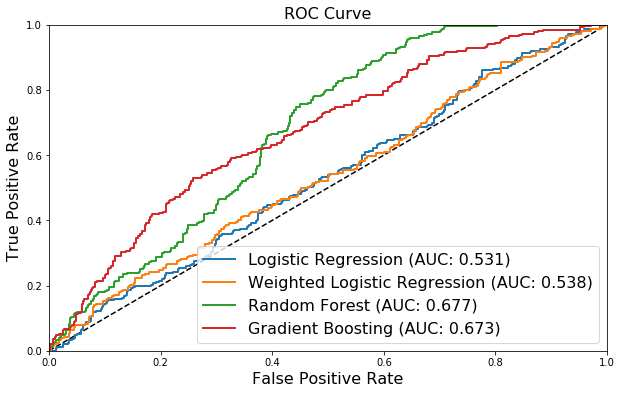

start printing ROC curve


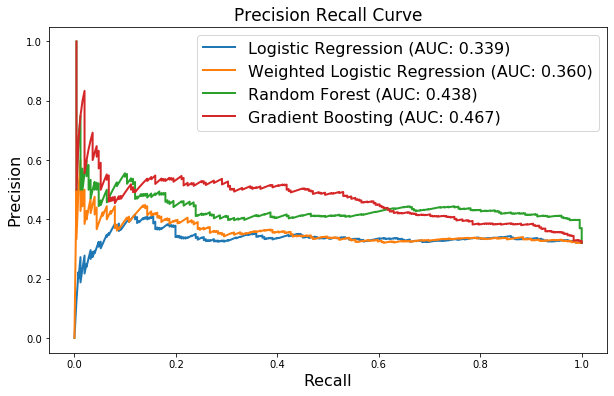

Best: 0.722222 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.352778 (0.248778) with: {'class_weight': {0: 1, 1: 10}}
0.722222 (0.229061) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 1000.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.5s finished


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
start printing ROC curve


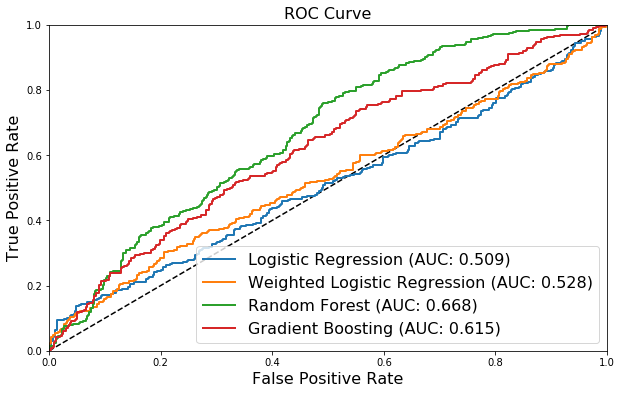

start printing ROC curve


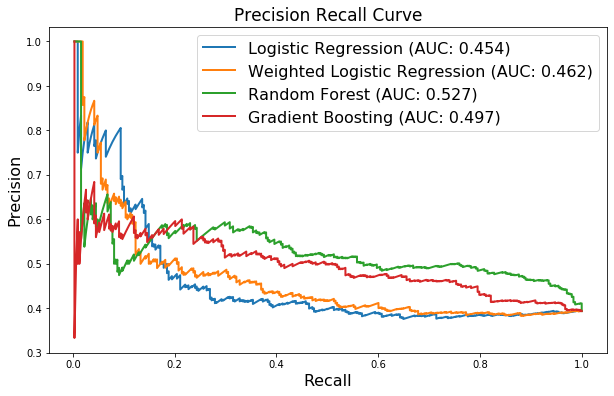

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.002564 (0.013808) with: {'class_weight': {0: 10, 1: 1}}
0.018803 (0.034119) with: {'class_weight': {0: 1, 1: 1}}
0.958547 (0.058977) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 1000.0}, 'max_depth': 6, 'max_features': 12}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.0s finished


xgb-best params are
{'max_features': 3, 'max_depth': 3, 'class_weight': 'balanced_subsample'}
start printing ROC curve


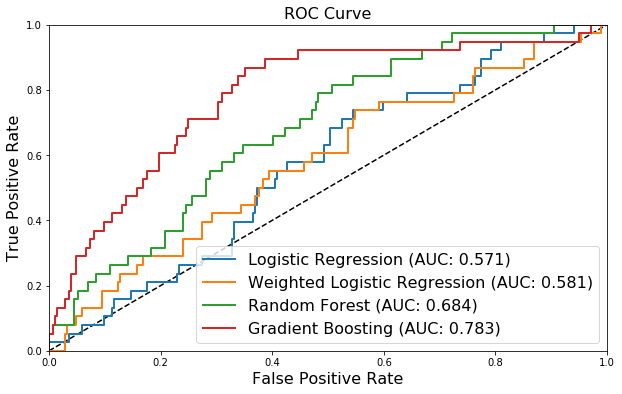

start printing ROC curve


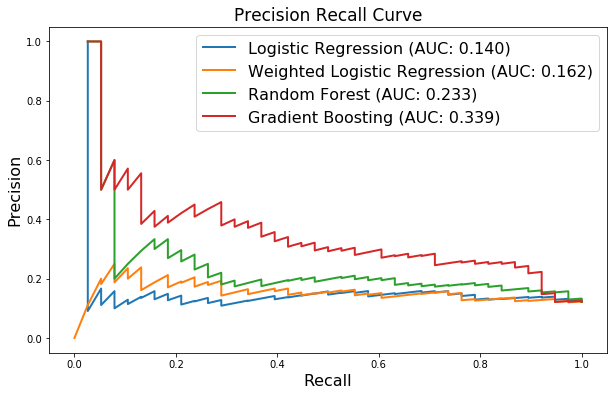

Best: 0.991667 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.010897 (0.027802) with: {'class_weight': {0: 1, 1: 1}}
0.915385 (0.078237) with: {'class_weight': {0: 1, 1: 10}}
0.991667 (0.025000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.1s finished


xgb-best params are
{'max_features': 13, 'max_depth': 5, 'class_weight': 'balanced'}
start printing ROC curve


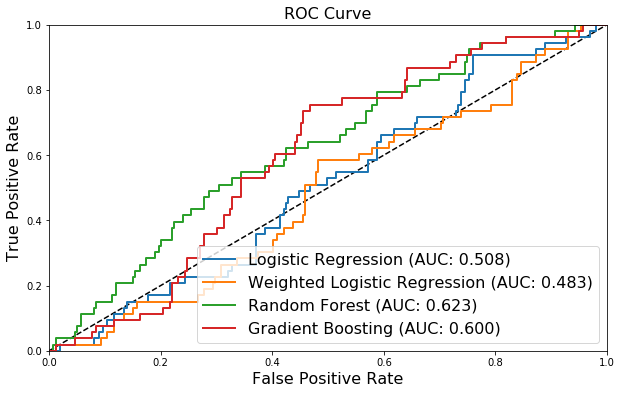

start printing ROC curve


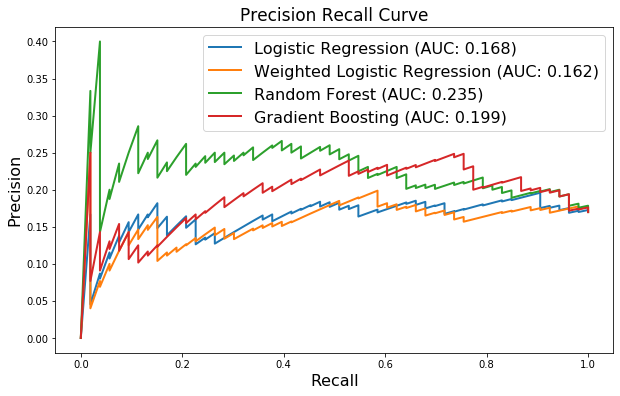

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.294658 (0.150211) with: {'class_weight': {0: 1, 1: 1}}
0.986966 (0.029164) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 11}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
start printing ROC curve


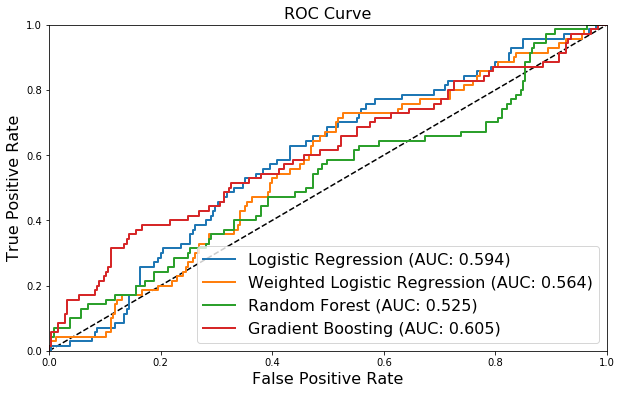

start printing ROC curve


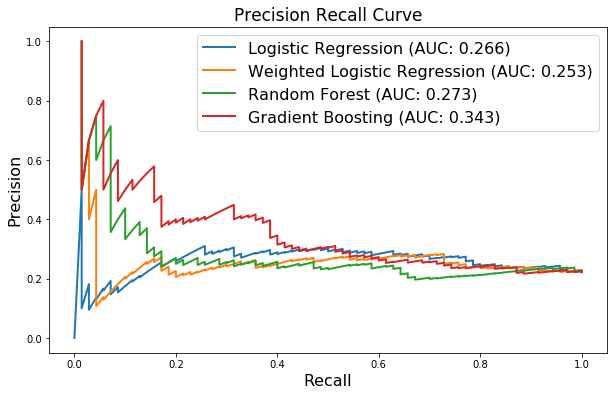

In [ ]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rf,pr_rf,roc_xgb,pr_xgb = roc_pr_values(country,df,measure,cut='bad')
            ROC_curve_plot(roc_lr,roc_lr_w,roc_rf,roc_xgb)
            pr_curve_plot(pr_lr,pr_lr_w,pr_rf,pr_xgb)

#### ROC curve for the secure vs not"

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 1000.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.4s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
start printing ROC curve


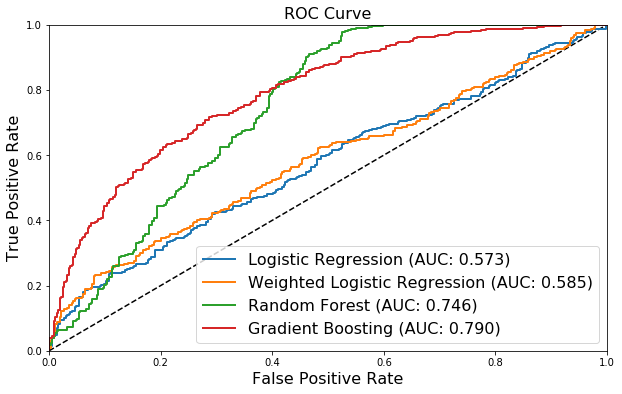

start printing ROC curve


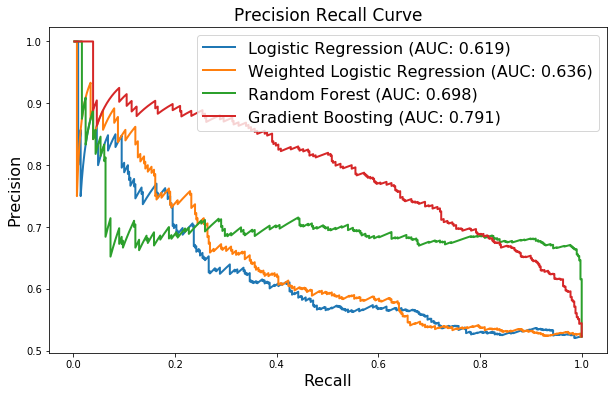

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) with: {'class_weight': {0: 10, 1: 1}}
0.470053 (0.070767) with: {'class_weight': {0: 1, 1: 1}}
0.970000 (0.030840) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


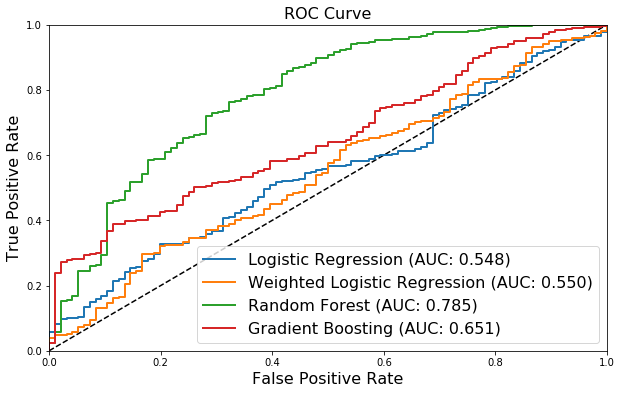

start printing ROC curve


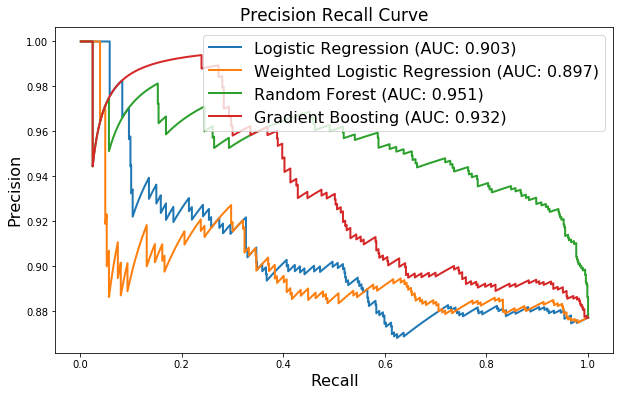

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.098254 (0.069023) with: {'class_weight': {0: 1, 1: 1}}
0.929206 (0.081693) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 12}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
start printing ROC curve


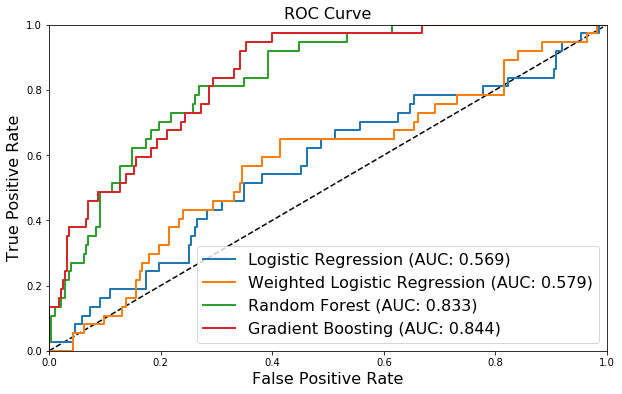

start printing ROC curve


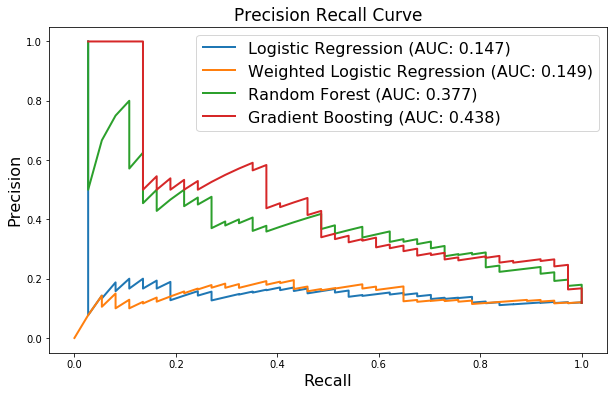

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.318519 (0.090520) with: {'class_weight': {0: 1, 1: 1}}
0.996296 (0.011111) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.2s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
start printing ROC curve


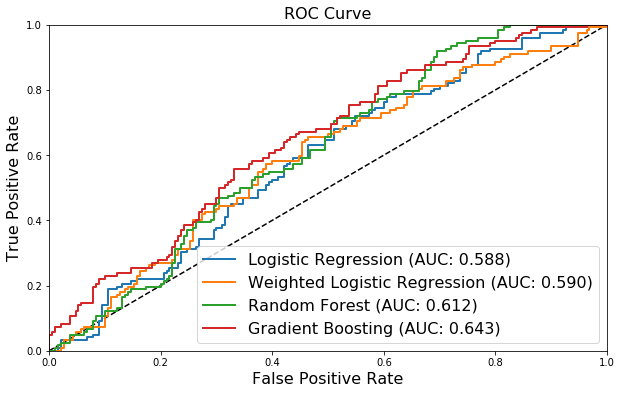

start printing ROC curve


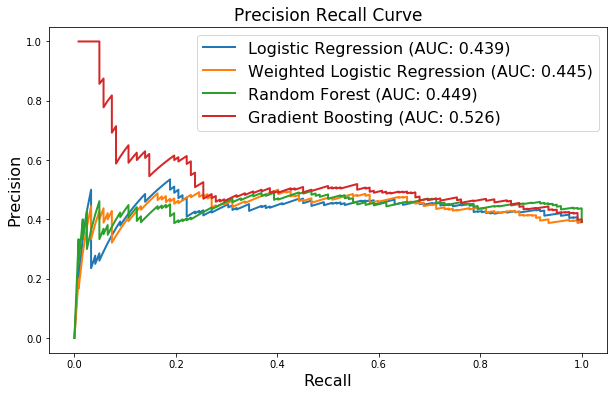

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.290110 (0.140902) with: {'class_weight': {0: 1, 1: 1}}
0.989744 (0.026149) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 11}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


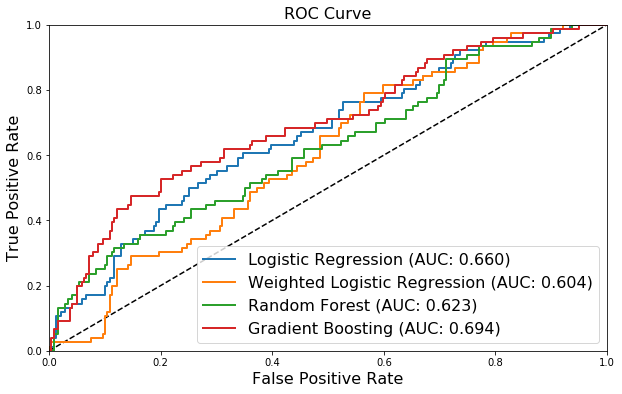

start printing ROC curve


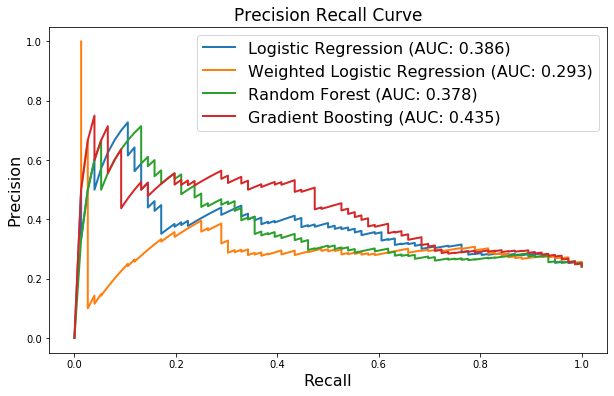

In [ ]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rf,pr_rf,roc_xgb,pr_xgb = roc_pr_values(country,df,measure,cut='safe')
            ROC_curve_plot(roc_lr,roc_lr_w,roc_rf,roc_xgb)
            pr_curve_plot(pr_lr,pr_lr_w,pr_rf,pr_xgb)

rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       0.99      0.52      0.68       771
    minority       0.02      0.64      0.04        11

    accuracy                           0.52       782
   macro avg       0.50      0.58      0.36       782
weighted avg       0.98      0.52      0.67       782
 

[[398 373]
 [  4   7]]
Percent of False Negatives 

0.51
Percent of False Positive  

47.7
average magnitude of false negatives  

average magnitude of false positives  

-46.19


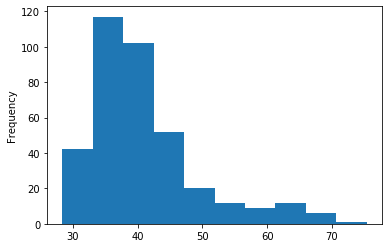

In [ ]:
mw_village['FCS'][change.index[np.where(change == -1)]].plot.hist()

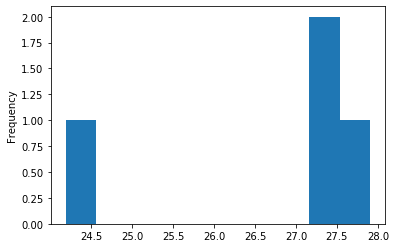

In [ ]:
mw_village['FCS'][change.index[np.where(change == 1)]].plot.hist()

In [ ]:
from sklearn.metrics import confusion_matrix

#### MW rCSI

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"rCSI",cut='bad')
threshold=0.03
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train,y_train,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(17 - mw_village['rCSI'][change.index[np.where(change == 1)]])/17 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(17 - mw_village['rCSI'][change.index[np.where(change == -1)]])/17 *100,2))


rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       0.93      0.35      0.51       723
    minority       0.08      0.69      0.14        59

    accuracy                           0.37       782
   macro avg       0.51      0.52      0.33       782
weighted avg       0.87      0.37      0.48       782
 

[[252 471]
 [ 18  41]]
Percent of False Negatives 

2.3
Percent of False Positive  

60.23
average magnitude of false negatives  

-19.17
average magnitude of false positives  

49.82


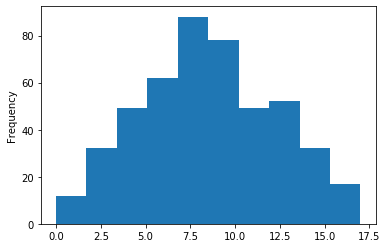

In [ ]:
mw_village['rCSI'][change.index[np.where(change == -1)]].plot.hist()

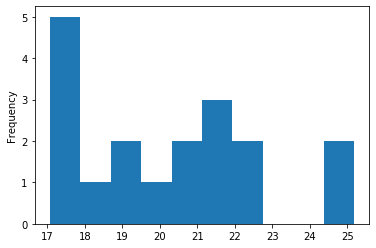

In [ ]:
mw_village['rCSI'][change.index[np.where(change == 1)]].plot.hist()

In [ ]:
country="mw"
df = mw_village
measure = 'FCS'
category = measure+'_20_'+'bad'

df_test,df_train = year_split(country, df)
X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)

threshold=0.04
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train,y_train,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))



rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       0.93      0.41      0.57       723
    minority       0.08      0.64      0.14        59

    accuracy                           0.42       782
   macro avg       0.51      0.52      0.35       782
weighted avg       0.87      0.42      0.53       782
 

[[293 430]
 [ 21  38]]
Percent of False Negatives 

2.69
Percent of False Positive  

54.99
average magnitude of false negatives  

-38.3
average magnitude of false positives  

-57.28


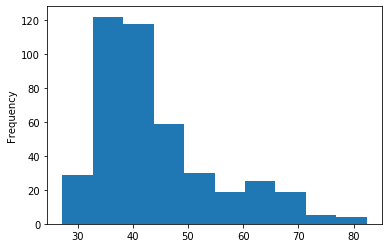

In [ ]:
print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))


mw_village['FCS'][change.index[np.where(change == -1)]].plot.hist()

In [ ]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("ug",ug_village,"FCS",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - ug_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - ug_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))


rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       1.00      0.52      0.68       308
    minority       0.04      1.00      0.09         7

    accuracy                           0.53       315
   macro avg       0.52      0.76      0.38       315
weighted avg       0.98      0.53      0.67       315
 

[[159 149]
 [  0   7]]
Percent of False Negatives 

0.0
Percent of False Positive  

47.3
average magnitude of false negatives  

nan
average magnitude of false positives  

-66.56


In [ ]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"rCSI",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = xgbCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - tz_village['rCSI'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - tz_village['rCSI'][change.index[np.where(change == -1)]])/28 *100,2))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.3s finished


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       1.00      0.79      0.88       307
    minority       0.06      0.80      0.11         5

    accuracy                           0.79       312
   macro avg       0.53      0.80      0.50       312
weighted avg       0.98      0.79      0.87       312
 

[[243  64]
 [  1   4]]
Percent of False Negatives 

0.32
Percent of False Positive  

20.51
average magnitude of false negatives  

33.04
average magnitude of false positives  

77.41


In [ ]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"rCSI",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = xgbCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - mw_village['rCSI'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - mw_village['rCSI'][change.index[np.where(change == -1)]])/28 *100,2))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished


xgb-best params are
{'max_features': 6, 'max_depth': 10, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       0.93      0.95      0.94       723
    minority       0.12      0.08      0.10        59

    accuracy                           0.88       782
   macro avg       0.52      0.52      0.52       782
weighted avg       0.87      0.88      0.87       782
 

[[686  37]
 [ 54   5]]
Percent of False Negatives 

6.91
Percent of False Positive  

4.73
average magnitude of false negatives  

27.13
average magnitude of false positives  

69.72


In [ ]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"FCS",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))


In [ ]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"FCS",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.78      0.87       771
minority_class       0.02      0.36      0.04        11

      accuracy                           0.77       782
     macro avg       0.51      0.57      0.46       782
  weighted avg       0.97      0.77      0.86       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.50      0.66       771
minority_class       0.02      0.73      0.04        11

      accuracy                           0.50  

In [ ]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"rCSI",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.77      0.84       723
minority_class       0.11      0.34      0.16        59

      accuracy                           0.74       782
     macro avg       0.52      0.55      0.50       782
  weighted avg       0.87      0.74      0.79       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92  

In [ ]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"FCS",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.94      0.97       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.94       312
     macro avg       0.50      0.47      0.48       312
  weighted avg       0.99      0.94      0.97       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.400000 (0.489898) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.19      0.31       311
minority_class       0.00      1.00      0.01         1

      accuracy                           0.19  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 6, 'max_depth': 10, 'class_weight': 'balanced'}
----------------xgb model baseline---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.86      0.92       311
minority_class       0.02      1.00      0.04         1

      accuracy                           0.86       312
     macro avg       0.51      0.93      0.48       312
  weighted avg       1.00      0.86      0.92       312
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 6, 'max_depth': 10, 'class_weight': 'balanced'}
----------------xgb model upsample---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.43      0.61       311
minority_class       0.01      1.00      0.01         1

      accuracy                           0.44       312
     macro avg       0.50      0.72      0.31       312
  weighted avg       1.00      0.44      0.60       312
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model smote---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.85      0.92       311
minority_class       0.02      1.00      0.04         1

      accuracy                           0.85       312
     macro avg       0.51      0.92      0.48       312
  weighted avg       1.00      0.85      0.92       312
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.79      0.88       311
minority_class       0.01      1.00      0.03         1

      accuracy                           0.79       312
     macro avg       0.51      0.89      0.46       312
  weighted avg       1.00      0.79      0.88       312
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.2s finished


In [ ]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"rCSI",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.92      0.95       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.90       312
     macro avg       0.49      0.46      0.47       312
  weighted avg       0.97      0.90      0.93       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.283333 (0.401732) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.06      0.12       307
minority_class       0.01      0.80      0.03         5

      accuracy                           0.07  

In [ ]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("ug",ug_village,"FCS",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.08)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98       315
     macro avg       0.49      0.50      0.49       315
  weighted avg       0.96      0.98      0.97       315
 

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.300000 (0.458258) with: {'class_weight': {0: 1, 1: 10}}
0.433333 (0.495536) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model baseline---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.93      0.96       308
minority_class       0.19      0.71      0.30         7

      accuracy                           0.93       315
     macro avg       0.59      0.82      0.63       315
  weighted avg       0.98      0.93      0.95       315
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model upsample---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.89      0.94       308
minority_class       0.15      0.86      0.26         7

      accuracy                           0.89       315
     macro avg       0.58      0.88      0.60       315
  weighted avg       0.98      0.89      0.93       315
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model smote---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.84      0.91       308
minority_class       0.11      0.86      0.19         7

      accuracy                           0.84       315
     macro avg       0.55      0.85      0.55       315
  weighted avg       0.98      0.84      0.90       315
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.92      0.96       308
minority_class       0.20      0.86      0.32         7

      accuracy                           0.92       315
     macro avg       0.60      0.89      0.64       315
  weighted avg       0.98      0.92      0.94       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


### Exploration of using percentage of insecure (continous measure)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import pearsonr

def lr(X_train,y_train,X_test, y_test):
    '''linear_reg'''
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def lasso(X_train,y_train,X_test, y_test):
    '''lasso'''
    reg = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=500, cv=10).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

from sklearn.linear_model import ElasticNetCV

def elastic(X_train,y_train,X_test, y_test):
    '''elasticNet'''
    reg = ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=500, cv=10).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def rf(X_train,y_train,X_test, y_test):
    '''rfc'''
    rf_reg = RandomForestRegressor(max_features='auto', n_estimators = 500,warm_start=True)

    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_reg, 
            param_distributions = random_grid,
            refit ='recall', 
            n_iter = 30, cv = 3, verbose=0, random_state=666, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    y_pred = rf_random.predict(X_test)
    
    return y_test,y_pred

def xgb(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_reg = XGBRegressor(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
   
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_reg, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=0, random_state=666, n_jobs = -1)
    # Fit the random search model
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    y_pred = XGB_random.predict(X_test)
         
    return y_test,y_pred
    
def r2_percent_low(country,df,measure,model):
    
    percent = measure+'_low_percent'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[0]**2,3)
    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

def r2_percent_mid_low(country,df,measure,model):
    
    percent = measure+'_mid+low'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[0]**2,3)    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

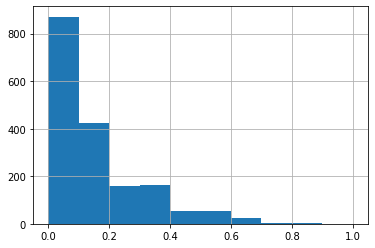

In [ ]:
mw_village['FCS_low_percent'].hist()

In [ ]:
percent_results_low = pd.DataFrame(columns = ['country','measure','model', 'r2']) 

model_list= [lr,lasso,elastic,rf]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                percent_results_low = percent_results_low.append(r2_percent_low(country,df,measure,model),ignore_index=True)
percent_results_low                

,country,measure,model,r2
0,mw,FCS,linear_reg,0.000
1,mw,rCSI,linear_reg,0.001
2,tz,FCS,linear_reg,0.116
3,tz,rCSI,linear_reg,0.085
4,ug,FCS,linear_reg,0.037
5,mw,FCS,lasso,0.081
6,mw,rCSI,lasso,0.016
7,tz,FCS,lasso,0.117
8,tz,rCSI,lasso,0.031
9,ug,FCS,lasso,0.046


In [ ]:
percent_results_mid_low = pd.DataFrame(columns = ['country','measure','model', 'r2']) 

model_list= [lr,lasso,elastic,rf]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                percent_results_mid_low = percent_results_mid_low.append(r2_percent_mid_low(country,df,measure,model),ignore_index=True)
percent_results_mid_low                

,country,measure,model,r2
0,mw,FCS,linear_reg,0.008
1,mw,rCSI,linear_reg,0.000
2,tz,FCS,linear_reg,0.205
3,tz,rCSI,linear_reg,0.082
4,ug,FCS,linear_reg,0.121
5,mw,FCS,lasso,0.138
6,mw,rCSI,lasso,0.033
7,tz,FCS,lasso,0.237
8,tz,rCSI,lasso,0.094
9,ug,FCS,lasso,0.138


### Feature importance

random forest and gradient boosting model choice 

In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2_rf_score(rf, X_train, y_train):
    return r2_score(y_train, rf_random.best_estimator_.predict(X_train))

    perm_imp_rfpimp = permutation_importances(rf_random.best_estimator_, X_train, y_train, r2_rf_score)

    return ax,params,perm_imp_rfpimp

In [5]:
tree_clf = DecisionTreeClassifier(random_state=66)
    
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
# n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

random_grid = {#'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth
                #'min_samples_split': min_samples_split
                #'min_samples_leaf': min_samples_leaf}
                #'bootstrap': bootstrap
                }

tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)

X_train = mw_clust_X_train_16
y_train = mw_clust_y_train_16['FCS_category']
tree_random.fit(X_train, y_train)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_random.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


NameError: name 'mw_clust_X_train_16' is not defined

### Error Analysis

In [ ]:
ug12 = pd.DataFrame({ 'ug12_FCS_truth':ug12_FCS_truth, 'ug_FCS_LR' : ug12_FCS_LR, 'ug_FCS_RFC' : ug12_FCS_RFC}).reset_index(drop=True)
ug_map = pd.concat([ug_ea_id.reset_index(drop=True),ug12 ], axis=1, ignore_index=True)
ug_map.columns=['ea_id','FS_year','lat_modified','lon_modified','ug12_FCS_truth','ug_FCS_LR','ug_FCS_RFC']



In [ ]:
print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))


mw_village['FCS'][change.index[np.where(change == -1)]].plot.hist()

### Three category results 


In [ ]:
def pre_rec_f1_support_minority(y_pred,y_test):
    
    if len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==3:
        precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][2]
        recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][2]
        fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][2]
        support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][2]

    elif len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==2:
 #   precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
 #   recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
 #   fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
 #   support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]

        precision = np.nan
        recall = np.nan
        fscore = np.nan
        support = np.nan

    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy    
 
def pre_rec_f1_support_mid(y_pred,y_test):

    precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
    recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
    fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
    support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]
    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy        

def metrics_3_category_severe(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_minority(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

def metrics_3_category_mid(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_mid(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

# create a table of results for the third category

third_category_severe = pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_severe = third_category_severe.append(metrics_3_category_severe(country,df,measure,model),ignore_index=True)
                
# create a table of results for the third category

third_category_mid= pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_mid = third_category_mid.append(metrics_3_category_mid(country,df,measure,model),ignore_index=True)                